# Notebook to test the scOPE code

Andrew Ashford, Pathways + Omics Group, OHSU
5/24/2024

This workflow will use bulk RNA-seq counts and variant call data to train logistic ridge regression classifiers to predict the presence or absence of cancer-associated mutations. I will then apply the models to single-cell data and perform additional experiments to determine clonal structures. This notebook is meant to implement and debug/test the code for this workflow as I write it.

NOTE: This notebook differs from code_test_notebook.ipynb in that I'm using integrated data and its PCs to train and test the model. You can refer to integrating_scRNA_and_bulk_RNA_AML_data.ipynb for steps taken to do this and where the integrated data object was saved.

In [2]:
# Import modules
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score


In [14]:
# Core scverse libraries
import anndata as ad

# Data retrieval
import pooch

sc.settings.set_figure_params(dpi=50, facecolor="white")

In [3]:
# Load in the data like so
# Specify the path to the saved file
#file_path = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/integrated_BeatAML_vanGalen_data/integrated_data.h5ad'

# Scanorama-integrated data with 100-variable latent space as .X
#file_path = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/Scanorama-integrated_Beat_AML_vanGalen_AML_adata.h5ad'

# Combined data - both data types are normalized and scaled
file_path = '/Users/hamiltsy/Documents/GitLab/Mutation/combined_Beat_AML_K22_AML_adata.h5ad'


# Load the AnnData object
integrated_data = sc.read_h5ad(file_path)

In [4]:
# Get top 2000 most variable genes for feature input into model
sc.pp.highly_variable_genes(integrated_data, n_top_genes=2000)

# Subset the AnnData object to keep only the highly variable genes
integrated_data = integrated_data[:, integrated_data.var['highly_variable']].copy()

# Check the resulting AnnData object
print(integrated_data)


AnnData object with n_obs × n_vars = 9194 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'dataset'
    var: 'highly_variable', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'


In [5]:
# Verify the contents of the loaded data
print(integrated_data)
print(integrated_data.X)
print(integrated_data.X.min())
print(integrated_data.X.max())
#print(integrated_data.obsm['X_pca'])
#print(integrated_data.obsm['X_pca'].shape)


AnnData object with n_obs × n_vars = 9194 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'dataset'
    var: 'highly_variable', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
[[-0.09084304 -0.04300602 -0.10632736 ...  0.51089371  0.58695247
  -0.33136084]
 [-0.09084304 -0.04300602 -0.10632736 ...  0.78187145  0.4060942
  -0.33136084]
 [-0.09084304 -0.04300602 -0.10632736 ...  0.62678177  0.2205675
   1.56877481]
 ...
 [-0.20332378  0.56514508  2.43931413 ...  0.27417898 -0.78779399
   0.22500519]
 [-0.48243037 -0.56164068 -1.43624973 ...  0.17563798  1.51378751
   1.4690876 ]
 [ 0.92265493 -0.55553317  0.11619364 ...  0.3616147   0.30547392


In [6]:
print(integrated_data.obs)
print(integrated_data.X)
print(integrated_data.X.max())
print(integrated_data.X.min())


                      orig.ident  nCount_RNA  nFeature_RNA  n_genes_by_counts  \
AAACCAAAGCAACCTA-1-0         0.0      3472.0        1460.0             1460.0   
AAACCAAAGCGATGTC-1-0         0.0      5875.0        2315.0             2315.0   
AAACCAAAGCTATGAT-1-0         0.0      7561.0        2260.0             2260.0   
AAACCAAAGGTATCTG-1-0         0.0      5887.0        2394.0             2394.0   
AAACCAAAGTAATCAC-1-0         0.0      2434.0        1068.0             1068.0   
...                          ...         ...           ...                ...   
BA3385R-1                    NaN         NaN           NaN                NaN   
BA3242R-1                    NaN         NaN           NaN                NaN   
BA3446R-1                    NaN         NaN           NaN                NaN   
BA3416R-1                    NaN         NaN           NaN                NaN   
BA3123R-1                    NaN         NaN           NaN                NaN   

                      total

In [24]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
#integrated_data.var["mt"] = integrated_data.var_names.str.startswith("MT-")
# ribosomal genes
#integrated_data.var["ribo"] = integrated_data.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
#integrated_data.var["hb"] = integrated_data.var_names.str.contains("^HB[^(P)]")

#sc.pp.calculate_qc_metrics(
#    integrated_data, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
#)

# Add basic QC metrics
sc.pp.calculate_qc_metrics(integrated_data, inplace=True)

# Confirm the columns exist now
print(integrated_data.obs.columns)



/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes',
       'dataset', 'log1p_n_genes_by_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo',
       'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb',
       'pct_counts_hb'],
      dtype='object')


/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


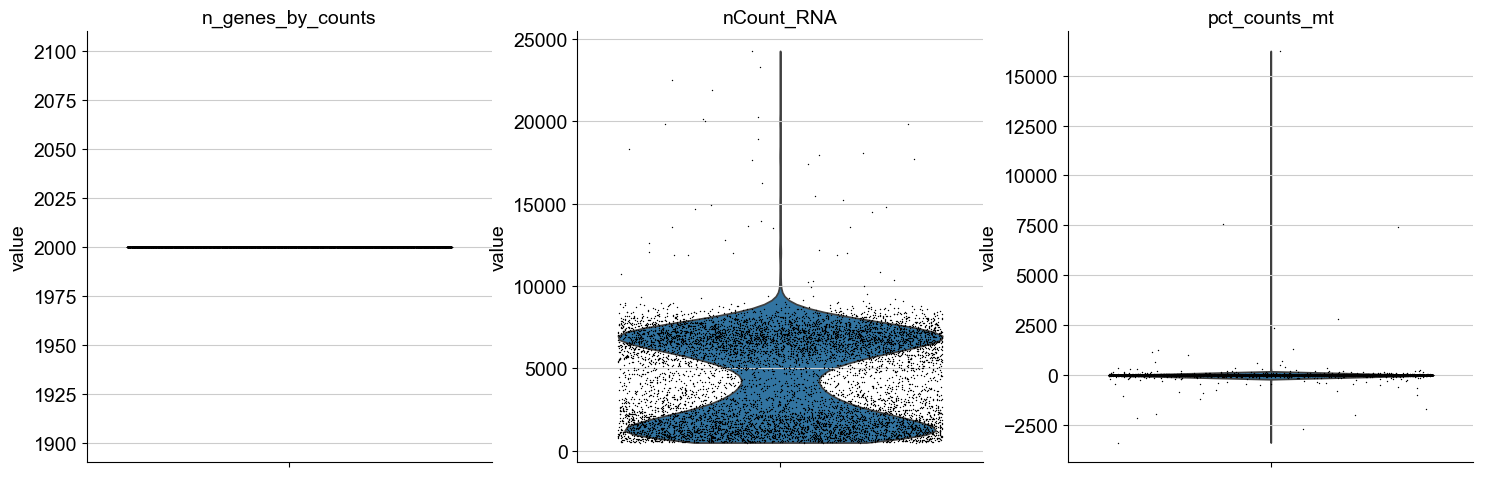

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes',
       'dataset', 'log1p_n_genes_by_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo',
       'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb',
       'pct_counts_hb', 'leiden'],
      dtype='object')


In [178]:
sc.pl.violin(
    integrated_data,
    ["n_genes_by_counts", "nCount_RNA", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

print(integrated_data.obs.columns)  # Check if 'n_genes_by_counts' exists


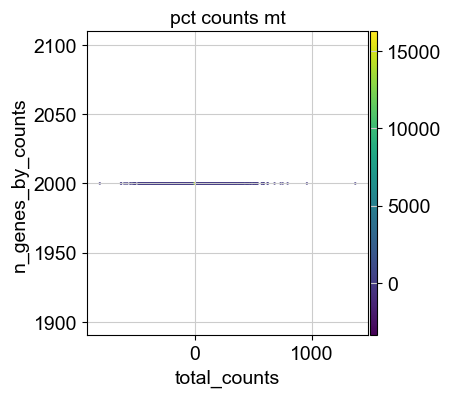

In [26]:
sc.pl.scatter(integrated_data, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [12]:
print(integrated_data.obsm.keys())  # Check if 'X_pca' exists
sc.pp.neighbors(integrated_data, n_neighbors=10, use_rep='X_pca')  # Ensure compatibility

print(integrated_data.X.shape)  # Shape of the expression matrix
print(integrated_data.obs.shape)  # Number of cells
print(integrated_data.var.shape)  # Number of genes

#integrated_data = integrated_data[:, integrated_data.var_names].copy()

#sc.tl.pca(integrated_data, svd_solver='arpack')
#print(integrated_data.obsm.keys())  # Confirm 'X_pca' exists

#del integrated_data.uns['neighbors']
#sc.pp.neighbors(integrated_data, n_neighbors=10, use_rep='X_pca')


# Run Leiden clustering
#sc.tl.leiden(integrated_data, resolution=0.5)  # Adjust resolution as needed


#sc.tl.umap(integrated_data)
#sc.pl.umap(integrated_data, color=['leiden'])


KeysView(AxisArrays with keys: )


ValueError: Did not find X_pca in `.obsm.keys()`. You need to compute it first.

In [27]:
# Build UMAP
sc.tl.pca(integrated_data)
sc.pp.neighbors(integrated_data)
sc.tl.umap(integrated_data)


/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


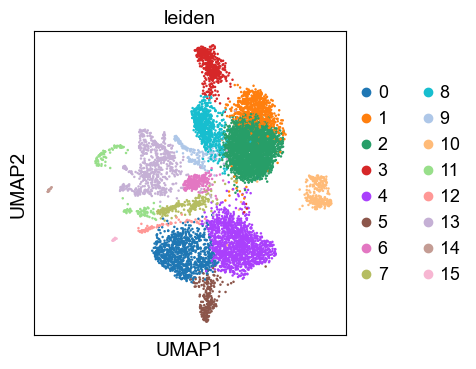

In [29]:
#sc.pl.umap(integrated_data, color=['cell_type'])
sc.tl.leiden(integrated_data, flavor="igraph", n_iterations=2)
sc.pl.umap(integrated_data, color=['leiden'])


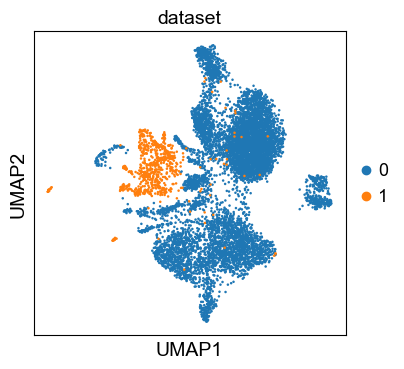

In [31]:
#sc.pl.umap(integrated_data, color=['dataset'])
sc.pl.umap(integrated_data, color=['dataset'])


In [15]:
# UMAP visualization of integrated data as a check
sc.pp.neighbors(integrated_data, use_rep='X_pca')
sc.tl.umap(integrated_data)


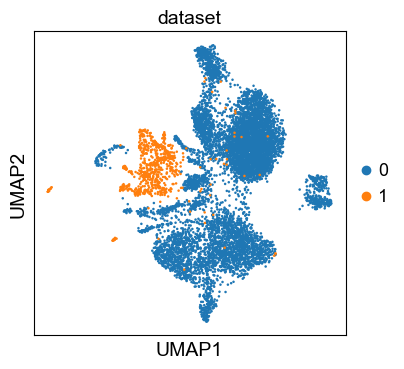

In [32]:
#sc.pl.umap(integrated_data, color=['dataset'])
sc.pl.umap(integrated_data, color=['dataset'])


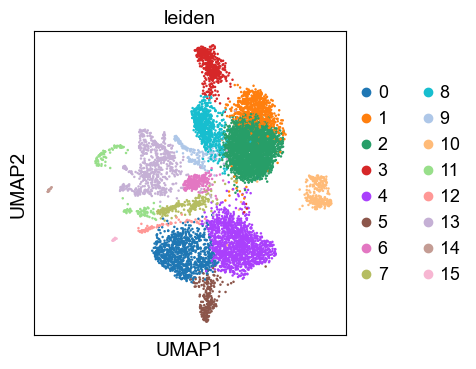

In [33]:
#sc.pl.umap(integrated_data, color=['cell_type'])
sc.pl.umap(integrated_data, color=['leiden'])


In [34]:
print(integrated_data.obsm['X_pca'])
print(integrated_data.obsm['X_pca'].shape)


[[  1.6387842   -6.714941     1.6158191  ...  -2.425827     1.2242045
    0.4518326 ]
 [ -2.112277     1.8602813    0.9013896  ...  -0.5759369    0.54663295
    0.2573033 ]
 [ -2.831503     1.3369675    0.14336732 ...  -0.3454366   -1.798273
    0.7099947 ]
 ...
 [  2.5498645   -7.4039564    2.4263856  ...  -0.54546624   1.605536
    0.03271649]
 [-18.555473   -10.963146    -4.952028   ...  -0.5029843   -0.93576187
   -1.2637591 ]
 [-10.951921    -3.6667218   -8.180081   ...   1.4582771    2.0074394
    0.95885485]]
(9194, 50)


In [35]:
# Load the bulk RNA-seq mutation data
mut_data = pd.read_csv('/Users/hamiltsy/Documents/GitLab/Mutation/beatAML_data/beataml_wes_wv1to4_mutations_dbgap.txt', sep='\t')

# Load the integrated AnnData object
#adata = sc.read_h5ad('/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/integrated_BeatAML_vanGalen_data/integrated_data.h5ad')
#adata = sc.read_h5ad('/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/Scanorama-integrated_Beat_AML_vanGalen_AML_adata.h5ad')
adata = sc.read_h5ad('/Users/hamiltsy/Documents/GitLab/Mutation/combined_Beat_AML_K22_AML_adata.h5ad')


In [36]:
# Scale all the .obsm['X_pca'] values
#scaler = StandardScaler()
#adata.obsm['X_pca'] = scaler.fit_transform(adata.obsm['X_pca'])
print(adata.obsm['X_pca'])
print(adata.obsm['X_pca'].shape)


KeyError: 'X_pca'

In [38]:
# Extract bulk RNA-seq data
bulk_data = adata[adata.obs['dataset'] == '1']
#bulk_data = adata[adata.obs['batch'] == 'bulk']

# Prepare the bulk RNA-seq data for model training
# Using the PCA data
# NOTE: Using .X instead of .obsm['X_pca']
#X_pca = bulk_data.obsm['X_pca']
X_pca = bulk_data.X


In [39]:
print(X_pca)
print(X_pca.shape)


[[-0.86029196 -0.14097153 -0.72666723 ...  0.14080305  0.07140068
  -0.07353657]
 [-0.95519769 -0.12970924 -0.68702263 ...  0.33362883 -0.5138917
   0.01531721]
 [-1.05363321 -0.19635452 -0.7285682  ...  0.37747142 -0.45817819
  -0.14230102]
 ...
 [-0.20332378  0.56514508  2.43931413 ... -0.78779399  0.22500519
   0.78945363]
 [-0.48243037 -0.56164068 -1.43624973 ...  1.51378751  1.4690876
   2.33954144]
 [ 0.92265493 -0.55553317  0.11619364 ...  0.30547392  0.58777618
   2.47961307]]
(707, 3992)


In [40]:
bulk_data.obs_names = bulk_data.obs_names.str.replace('R-bulk', 'D')


In [41]:
print(X_pca)
print(X_pca.shape)


[[-0.86029196 -0.14097153 -0.72666723 ...  0.14080305  0.07140068
  -0.07353657]
 [-0.95519769 -0.12970924 -0.68702263 ...  0.33362883 -0.5138917
   0.01531721]
 [-1.05363321 -0.19635452 -0.7285682  ...  0.37747142 -0.45817819
  -0.14230102]
 ...
 [-0.20332378  0.56514508  2.43931413 ... -0.78779399  0.22500519
   0.78945363]
 [-0.48243037 -0.56164068 -1.43624973 ...  1.51378751  1.4690876
   2.33954144]
 [ 0.92265493 -0.55553317  0.11619364 ...  0.30547392  0.58777618
   2.47961307]]
(707, 3992)


In [42]:
print(mut_data)


      dbgap_sample_id              capture_type seqnames  pos_start  \
0             BA2336D               NexteraV1.2        4  106156042   
1             BA2336D               NexteraV1.2        4  106190829   
2             BA2336D               NexteraV1.2        5  170837543   
3             BA2643D               NexteraV1.2       11   32456651   
4             BA2643D               NexteraV1.2        2   25457242   
...               ...                       ...      ...        ...   
11716         BA3100D  Nimblegen Custom Capture        2   25457242   
11717         BA3100D  Nimblegen Custom Capture        2   25457242   
11718         BA3100D  Nimblegen Custom Capture        5  170837543   
11719         BA3100D  Nimblegen Custom Capture        1  115258747   
11720         BA3100D  Nimblegen Custom Capture        1  115258747   

         pos_end ref    alt genotyper  tumor_only  total_reads  ...  \
0      106156043  TC      T   varscan           1          151  ...   
1    

In [43]:
# Ensure the mutation labels are binary
mutations = mut_data['symbol'].unique()

# Modify the sample IDs to match between RNA and mutation data
bulk_data.obs['dbgap_sample_id'] = bulk_data.obs.index.str.replace('R-1', 'D')


In [44]:
print(mutations)
print(len(mutations))
print(set(mutations))
print(len(set(mutations)))


['TET2' 'NPM1' 'WT1' ... 'PNMA3' 'SLC41A2' 'PPP1R3A']
3333
{'DTD1', 'GPATCH8', 'KMT2D', 'KLK11', 'RLN3', 'CARD14', 'ILF3', 'ADCY8', 'PGLYRP1', 'NEUROG1', 'ACTR5', 'ORC2', 'SLC28A2', 'CMAS', 'TRHDE', 'BMP2K', 'MAFB', 'SCAF1', 'TFAP4', 'SORBS2', 'ZP3', 'MAMDC4', 'ZNF487', 'NGEF', 'MCF2L', 'GSPT2', 'MCPH1', 'ARHGAP40', 'C1orf101', 'VANGL1', 'TXNDC5', 'EPB41L4A', 'NRAS', 'COBL', 'FAR2', 'ZNF587', 'SUN5', 'KIAA1429', 'CCND2', 'ITPRIPL1', 'PPL', 'SBNO2', 'NAT10', 'MORC4', 'SERPINA11', 'GRIN1', 'SLC26A7', 'MAPK13', 'ZRANB1', 'NTHL1', 'TMEM43', 'CEACAM19', 'C14orf39', 'HCN4', 'GANAB', 'PPIC', 'CASD1', 'RNF34', 'FOXN4', 'NAGS', 'TCEAL2', 'C17orf50', 'FOXD4', 'ZDHHC14', 'MASP1', 'FNDC3A', 'GPR124', 'ZFYVE28', 'CNN3', 'RPS6KA2', 'DIAPH2', 'SSH2', 'SLC22A6', 'KRT18', 'CHAD', 'THSD7A', 'FCN2', 'FLT4', 'KAT8', 'TFDP1', 'TSC2', 'BAK1', 'SLITRK5', 'DIRAS3', 'FASN', 'EVL', 'SIGIRR', 'SIPA1L2', 'SART1', 'CHCHD10', 'TFPI2', 'NOVA2', 'TRPM4', 'RIMBP3', 'CCT4', 'MNX1', 'TINAG', 'NSUN3', 'ZKSCAN1', 'JAK3', 

In [45]:
# Remove duplicate sample IDs in mutation data (if any)
mut_data = mut_data.drop_duplicates(subset=['dbgap_sample_id', 'symbol'])

# Create a binary matrix for mutation presence
mut_data_binary = pd.crosstab(mut_data['dbgap_sample_id'], mut_data['symbol'])


In [46]:
# Align mutation data with bulk RNA-seq data
bulk_sample_ids = bulk_data.obs['dbgap_sample_id']
mut_data_agg = mut_data_binary.reindex(bulk_sample_ids, fill_value=0)


In [47]:
print(mut_data_agg)


symbol           A1CF  A2M  A4GALT  AADAC  AADACL3  AADACL4  AAK1  AARS2  \
dbgap_sample_id                                                            
BA2392D             0    0       0      0        0        0     0      0   
BA2611D             0    0       0      0        0        0     0      0   
BA2506D             0    0       0      0        0        0     0      0   
BA2430D             0    0       0      0        0        0     0      0   
BA2448D             0    0       0      0        0        0     0      0   
...               ...  ...     ...    ...      ...      ...   ...    ...   
BA3385D             0    0       0      0        0        0     0      0   
BA3242D             0    0       0      0        0        0     0      0   
BA3446D             0    0       0      0        0        0     0      0   
BA3416D             0    0       0      0        0        0     0      0   
BA3123D             0    0       0      0        0        0     0      0   

symbol     

In [48]:
# Standardize the PCA data
#scaler = StandardScaler()
#X_pca_scaled = scaler.fit_transform(X_pca)
# Decided not to do this, but didn't want to mess up downstream stuff so I kept the variable name
X_pca_scaled = X_pca


In [49]:
# Initialize models
ridge_model = RidgeClassifierCV()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)


In [50]:
# Function to train and evaluate model with Stratified K-Folds
def train_evaluate_model(X, y, model, model_name, cv_splits, mut_name, auc_dict):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    #scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    #print(f"{model_name} - Cross-validation accuracy: {np.mean(scores)}")
    
    model_rstrip = model_name.rstrip(' ')
    auc_dict[mut_name][model_rstrip].append(np.mean(scores))
    
    print(f"{model_name} - Cross-validation ROC AUC: {np.mean(scores)}")


In [51]:
# User-defined minimum number of positive samples required
MIN_POSITIVE_SAMPLES = 10
DEFAULT_CV_SPLITS = 10

# Track mutations with sufficient positive samples
valid_mutations = []


In [52]:
# Keep the ROC AUC scores for each mutation in a dictionary
roc_auc_dict = {}


In [53]:
# Train and evaluate models
for mutation in mutations:
    #print(mutation)
    if mutation in mut_data_agg.columns:
        #print('mutation is in mut_data_agg.columns')
        
        y_mutation = mut_data_agg[mutation].astype(int)
        #print(y_mutation)
        
        # Check the distribution of the labels to ensure it makes sense
        positive_samples = np.sum(y_mutation)
        negative_samples = len(y_mutation) - positive_samples
        
        if positive_samples < MIN_POSITIVE_SAMPLES:
            continue
        
        # Dynamically set the number of CV splits
        cv_splits = min(DEFAULT_CV_SPLITS, positive_samples, negative_samples)
        
        if cv_splits < 2:
            continue
            
        if mutation not in roc_auc_dict.keys():
            roc_auc_dict[mutation] = {'Ridge Classifier': [], 'Random Forest Classifier': [], 'SVM Classifier': []}
        
        #print(roc_auc_dict)
        
        print(f"Training models for mutation: {mutation}")
        
        # Sample equal number of negative samples
        positive_indices = np.where(y_mutation == 1)[0]
        negative_indices = np.where(y_mutation == 0)[0]
        
        negative_indices_sampled = resample(negative_indices, replace=False, n_samples=positive_samples, random_state=42)
        
        # Combine positive and negative samples
        combined_indices = np.concatenate([positive_indices, negative_indices_sampled])
        X_pca_scaled_sampled = X_pca_scaled[combined_indices]
        y_mutation_sampled = y_mutation.iloc[combined_indices]
        
        train_evaluate_model(X_pca_scaled_sampled, y_mutation_sampled, ridge_model, "Ridge Classifier ", cv_splits, mutation, roc_auc_dict)
        train_evaluate_model(X_pca_scaled_sampled, y_mutation_sampled, rf_model, "Random Forest Classifier ", cv_splits, mutation, roc_auc_dict)
        train_evaluate_model(X_pca_scaled_sampled, y_mutation_sampled, svm_model, "SVM Classifier ", cv_splits, mutation, roc_auc_dict)
        
        valid_mutations.append(mutation)
        

Training models for mutation: TET2
Ridge Classifier  - Cross-validation ROC AUC: 0.7859375
Random Forest Classifier  - Cross-validation ROC AUC: 0.7921006944444444
SVM Classifier  - Cross-validation ROC AUC: 0.781423611111111
Training models for mutation: NPM1
Ridge Classifier  - Cross-validation ROC AUC: 0.9806802721088435
Random Forest Classifier  - Cross-validation ROC AUC: 0.9732482993197278
SVM Classifier  - Cross-validation ROC AUC: 0.9801360544217687
Training models for mutation: WT1
Ridge Classifier  - Cross-validation ROC AUC: 0.8560000000000001
Random Forest Classifier  - Cross-validation ROC AUC: 0.7525000000000001
SVM Classifier  - Cross-validation ROC AUC: 0.8530000000000001
Training models for mutation: DNMT3A
Ridge Classifier  - Cross-validation ROC AUC: 0.8197802197802198
Random Forest Classifier  - Cross-validation ROC AUC: 0.8222527472527472
SVM Classifier  - Cross-validation ROC AUC: 0.8089089481946624
Training models for mutation: SRSF2
Ridge Classifier  - Cross-val

In [54]:
# AUC score dict sanity check
print(roc_auc_dict)


{'TET2': {'Ridge Classifier': [0.7859375], 'Random Forest Classifier': [0.7921006944444444], 'SVM Classifier': [0.781423611111111]}, 'NPM1': {'Ridge Classifier': [0.9806802721088435], 'Random Forest Classifier': [0.9732482993197278], 'SVM Classifier': [0.9801360544217687]}, 'WT1': {'Ridge Classifier': [0.8560000000000001], 'Random Forest Classifier': [0.7525000000000001], 'SVM Classifier': [0.8530000000000001]}, 'DNMT3A': {'Ridge Classifier': [0.8197802197802198], 'Random Forest Classifier': [0.8222527472527472], 'SVM Classifier': [0.8089089481946624]}, 'SRSF2': {'Ridge Classifier': [0.9862244897959183], 'Random Forest Classifier': [0.9182397959183672], 'SVM Classifier': [0.9841836734693878]}, 'KRAS': {'Ridge Classifier': [0.7861111111111112], 'Random Forest Classifier': [0.7375], 'SVM Classifier': [0.7861111111111112]}, 'IDH2': {'Ridge Classifier': [0.8984693877551022], 'Random Forest Classifier': [0.874234693877551], 'SVM Classifier': [0.8966836734693878]}, 'BCOR': {'Ridge Classifier

In [157]:
scRNA_data = adata[adata.obs['dataset'] == '0']
#scRNA_data = adata[adata.obs['batch'] == 'scRNA']

# NOTE: Using .X instead of .obsm['X_pca']
#X_scRNA_pca = scRNA_data.obsm['X_pca']
X_scRNA_pca = scRNA_data.X
#X_scRNA_pca_scaled = scaler.transform(X_scRNA_pca)
X_scRNA_pca_scaled = X_scRNA_pca


In [158]:
print(X_scRNA_pca_scaled)
print(X_scRNA_pca_scaled.shape)
print(X_scRNA_pca_scaled.min())
print(X_scRNA_pca_scaled.max())


[[-0.09084304 -0.04300602 -0.10632736 ...  0.58695247 -0.33136084
  -0.14849041]
 [-0.09084304 -0.04300602 -0.10632736 ...  0.4060942  -0.33136084
  -0.14849041]
 [-0.09084304 -0.04300602 -0.10632736 ...  0.2205675   1.56877481
  -0.14849041]
 ...
 [-0.09084304 -0.04300602 -0.10632736 ... -1.35749965 -0.33136084
  10.        ]
 [-0.09084304 -0.04300602 -0.10632736 ... -0.25335662 -0.33136084
  -0.14849041]
 [-0.09084304 -0.04300602 -0.10632736 ... -0.42828647 -0.33136084
  -0.14849041]]
(8487, 3992)
-6.750442860322292
10.0


In [159]:
# Apply trained models to scRNA-seq data
print('Beginning to apply trained models to scRNA-seq data..')

# Dictionary to store prediction results
predictions = {}

print(valid_mutations)

# Apply predictions only for valid mutations
for mutation in valid_mutations:
    
    print(f'Predicting mutation status in single-cell data for mutation: {mutation}..')
    y_mutation = mut_data_agg[mutation].astype(int)
    
    # Train the final models
    ridge_model.fit(X_pca_scaled, y_mutation)
    rf_model.fit(X_pca_scaled, y_mutation)
    svm_model.fit(X_pca_scaled, y_mutation)
    
    # Predict using scRNA-seq data
    scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_model.predict(X_scRNA_pca_scaled)
    scRNA_data.obs[f'rf_preds_{mutation}'] = rf_model.predict(X_scRNA_pca_scaled)
    scRNA_data.obs[f'svm_preds_{mutation}'] = svm_model.predict(X_scRNA_pca_scaled)
    
    # Save predictions to dictionary
    predictions[f'ridge_preds_{mutation}'] = scRNA_data.obs[f'ridge_preds_{mutation}']
    predictions[f'rf_preds_{mutation}'] = scRNA_data.obs[f'rf_preds_{mutation}']
    predictions[f'svm_preds_{mutation}'] = scRNA_data.obs[f'svm_preds_{mutation}']

print("Models trained and predictions applied to scRNA-seq data.")    



Beginning to apply trained models to scRNA-seq data..
['SRSF2', 'ASXL1', 'FLT3', 'BCORL1', 'RUNX1', 'RAD21', 'TP53', 'CCND3', 'PTPN11', 'EZH2', 'IDH1', 'TET2', 'WT1', 'DNMT3A', 'NRAS', 'NF1', 'U2AF1', 'KRAS', 'CEBPA', 'SMC1A', 'KIT', 'JAK2', 'NPM1', 'SF3B1', 'CREBBP', 'GATA2', 'PDS5B', 'BCOR', 'IDH2', 'ZRSR2', 'SMC3', 'PHF6', 'STAG2', 'CBL']
Predicting mutation status in single-cell data for mutation: SRSF2..


/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_29546/3489598514.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_model.predict(X_scRNA_pca_scaled)


Predicting mutation status in single-cell data for mutation: ASXL1..
Predicting mutation status in single-cell data for mutation: FLT3..
Predicting mutation status in single-cell data for mutation: BCORL1..
Predicting mutation status in single-cell data for mutation: RUNX1..
Predicting mutation status in single-cell data for mutation: RAD21..
Predicting mutation status in single-cell data for mutation: TP53..
Predicting mutation status in single-cell data for mutation: CCND3..
Predicting mutation status in single-cell data for mutation: PTPN11..
Predicting mutation status in single-cell data for mutation: EZH2..
Predicting mutation status in single-cell data for mutation: IDH1..
Predicting mutation status in single-cell data for mutation: TET2..
Predicting mutation status in single-cell data for mutation: WT1..
Predicting mutation status in single-cell data for mutation: DNMT3A..
Predicting mutation status in single-cell data for mutation: NRAS..
Predicting mutation status in single-ce

/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_29546/3489598514.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_model.predict(X_scRNA_pca_scaled)
/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_29546/3489598514.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'rf_preds_{mutation}'] = rf_model.predict(X_scRNA_pca_scaled)


Models trained and predictions applied to scRNA-seq data.


/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_29546/3489598514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'svm_preds_{mutation}'] = svm_model.predict(X_scRNA_pca_scaled)


In [160]:
print(scRNA_data)

AnnData object with n_obs × n_vars = 8487 × 3992
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'dataset', 'ridge_preds_SRSF2', 'rf_preds_SRSF2', 'svm_preds_SRSF2', 'ridge_preds_ASXL1', 'rf_preds_ASXL1', 'svm_preds_ASXL1', 'ridge_preds_FLT3', 'rf_preds_FLT3', 'svm_preds_FLT3', 'ridge_preds_BCORL1', 'rf_preds_BCORL1', 'svm_preds_BCORL1', 'ridge_preds_RUNX1', 'rf_preds_RUNX1', 'svm_preds_RUNX1', 'ridge_preds_RAD21', 'rf_preds_RAD21', 'svm_preds_RAD21', 'ridge_preds_TP53', 'rf_preds_TP53', 'svm_preds_TP53', 'ridge_preds_CCND3', 'rf_preds_CCND3', 'svm_preds_CCND3', 'ridge_preds_PTPN11', 'rf_preds_PTPN11', 'svm_preds_PTPN11', 'ridge_preds_EZH2', 'rf_preds_EZH2', 'svm_preds_EZH2', 'ridge_preds_IDH1', 'rf_preds_IDH1', 'svm_preds_IDH1', 'ridge_preds_TET2', 'rf_preds_TET2', 'svm_preds_TET2', 'ridge_preds_WT1', 'rf_preds_WT1', 'svm_preds_WT1', 'ridge_preds_DNMT3A', 'rf_preds_DNMT3A', 'svm_preds_DNMT3A', 'ri

In [59]:
# Write the ROC AUC dictionary to a csv file
import csv

# Flatten the dictionary structure
flattened_data = []
for key, subdict in roc_auc_dict.items():
    for subkey, value_list in subdict.items():
        flattened_data.append([key, subkey] + value_list)

# Specify the CSV file name
csv_file = '/Users/hamiltsy/Documents/GitLab/Mutation/trained_models/roc_auc_dict_to_file.csv'

# Write the flattened data to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    max_list_length = max(len(lst) for subdict in roc_auc_dict.values() for lst in subdict.values())
    header = ['key', 'subkey'] + [f'value_{i+1}' for i in range(max_list_length)]
    writer.writerow(header)
    
    # Write the rows
    writer.writerows(flattened_data)

print(f"ROC AUC dict data has been written to {csv_file}")



ROC AUC dict data has been written to /Users/hamiltsy/Documents/GitLab/Mutation/trained_models/roc_auc_dict_to_file.csv


In [60]:
# Convert dictionary to DataFrame and save to CSV
predictions_df = pd.DataFrame(predictions, index=scRNA_data.obs_names)
predictions_df.to_csv('/Users/hamiltsy/Documents/GitLab/Mutation/trained_models/2000_gene_features_X_mutation_predictions.csv')

# Save the updated AnnData object
scRNA_data.write('/Users/hamiltsy/Documents/GitLab/Mutation/trained_models/2000_gene_features_adata_with_predictions.h5ad')


In [172]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Modules for new models
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Original models
'''
# Initialize your models
#ridge_model = RidgeClassifier()  # Note: RidgeClassifier does not have predict_proba
#rf_model = RandomForestClassifier()
#svm_model = SVC(probability=True)  # Make sure SVM is configured to output probabilities
'''
# Model training with hyperparameter tuning and calibration
ridge_model = CalibratedClassifierCV(RidgeClassifierCV(), method='sigmoid')
rf_model = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [100, 200], 'max_depth': [5, 10]}, cv=5)
svm_model = CalibratedClassifierCV(SVC(probability=True), method='sigmoid')
gbm_model = GridSearchCV(GradientBoostingClassifier(), param_grid={'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}, cv=5)

# Apply trained models to scRNA-seq data
print('Beginning to apply trained models to scRNA-seq data..')

# Dictionary to store prediction results
predictions = {}

valid_mutations = list(set(valid_mutations))
print(valid_mutations)

# Apply predictions only for valid mutations
for mutation in valid_mutations:
    print(f'Predicting mutation status in single-cell data for mutation: {mutation}..')
    y_mutation = mut_data_agg[mutation].astype(int)
    
    # Train the final models on bulk RNA-seq data
    ridge_model.fit(X_pca_scaled, y_mutation)
    rf_model.fit(X_pca_scaled, y_mutation)
    svm_model.fit(X_pca_scaled, y_mutation)
    gbm_model.fit(X_pca_scaled, y_mutation)
    
    '''
    # Predict using scRNA-seq data
    # RidgeClassifier does not have predict_proba, using decision_function instead
    ridge_probs = ridge_model.decision_function(X_scRNA_pca_scaled)
    rf_probs = rf_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    svm_probs = svm_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    '''
    # Predict using scRNA-seq data
    ridge_probs = ridge_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    rf_probs = rf_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    svm_probs = svm_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    #gbm_probs = gbm_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    
    # Combine predictions using an ensemble method (e.g., average)
    #ensemble_probs = (ridge_probs + rf_probs + svm_probs + gbm_probs) / 4
    
    scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_probs
    scRNA_data.obs[f'rf_preds_{mutation}'] = rf_probs
    scRNA_data.obs[f'svm_preds_{mutation}'] = svm_probs
    # New preds
    #scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
    #scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs
    
    # Save predictions to dictionary
    predictions[f'ridge_preds_{mutation}'] = ridge_probs
    predictions[f'rf_preds_{mutation}'] = rf_probs
    predictions[f'svm_preds_{mutation}'] = svm_probs
    # New preds
    #predictions[f'gbm_preds_{mutation}'] = gbm_probs
    #predictions[f'ensemble_preds_{mutation}'] = ensemble_probs

    '''
    # Additionally, save the predicted probabilities for the bulk RNA-seq data
    ridge_bulk_probs = ridge_model.decision_function(X_pca_scaled)
    rf_bulk_probs = rf_model.predict_proba(X_pca_scaled)[:, 1]
    svm_bulk_probs = svm_model.predict_proba(X_pca_scaled)[:, 1]
    '''
    ridge_bulk_probs = ridge_model.predict_proba(X_pca_scaled)[:, 1]
    rf_bulk_probs = rf_model.predict_proba(X_pca_scaled)[:, 1]
    svm_bulk_probs = svm_model.predict_proba(X_pca_scaled)[:, 1]
    
    predictions[f'ridge_bulk_probs_{mutation}'] = ridge_bulk_probs
    predictions[f'rf_bulk_probs_{mutation}'] = rf_bulk_probs
    predictions[f'svm_bulk_probs_{mutation}'] = svm_bulk_probs

print("Models trained and predictions applied to scRNA-seq data.")


Beginning to apply trained models to scRNA-seq data..
['SRSF2', 'ASXL1', 'FLT3', 'BCORL1', 'RUNX1', 'TP53', 'RAD21', 'CCND3', 'PTPN11', 'EZH2', 'IDH1', 'WT1', 'TET2', 'DNMT3A', 'NRAS', 'NF1', 'U2AF1', 'KRAS', 'CEBPA', 'SMC1A', 'KIT', 'JAK2', 'NPM1', 'SF3B1', 'CREBBP', 'GATA2', 'PDS5B', 'BCOR', 'IDH2', 'ZRSR2', 'SMC3', 'PHF6', 'STAG2', 'CBL']
Predicting mutation status in single-cell data for mutation: SRSF2..
Predicting mutation status in single-cell data for mutation: ASXL1..
Predicting mutation status in single-cell data for mutation: FLT3..
Predicting mutation status in single-cell data for mutation: BCORL1..
Predicting mutation status in single-cell data for mutation: RUNX1..
Predicting mutation status in single-cell data for mutation: TP53..
Predicting mutation status in single-cell data for mutation: RAD21..
Predicting mutation status in single-cell data for mutation: CCND3..
Predicting mutation status in single-cell data for mutation: PTPN11..
Predicting mutation status in singl

In [161]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import numpy as np

def permutation_test_auc(bulk_y_true, bulk_probs, n_permutations=1000):
    # Calculate the observed AUC using the bulk RNA-seq data
    observed_auc = roc_auc_score(bulk_y_true, bulk_probs)
    
    # Generate the null distribution by permuting the labels
    permuted_aucs = np.zeros(n_permutations)
    for i in range(n_permutations):
        permuted_labels = shuffle(bulk_y_true)
        permuted_aucs[i] = roc_auc_score(permuted_labels, bulk_probs)
    
    # Calculate the p-value
    p_value = (np.sum(permuted_aucs >= observed_auc) + 1) / (n_permutations + 1)
    
    return observed_auc, p_value



In [167]:
#mutation = 'TP53'
#mutation = 'FLT3'
mutation = 'NPM1'
#mutation = 'NRAS'

bulk_y_true = mut_data_agg[mutation].astype(int)
ridge_bulk_probs = predictions[f'ridge_bulk_probs_{mutation}']

# Check the shapes
print("Shape of bulk_y_true:", bulk_y_true.shape)
print("Shape of ridge_bulk_probs:", ridge_bulk_probs.shape)

# Calculate AUC and p-value
observed_auc, p_value = permutation_test_auc(bulk_y_true, ridge_bulk_probs)
print(f"Observed AUC for {mutation}: {observed_auc}")
print(f"P-value: {p_value}")


KeyError: 'ridge_bulk_probs_NPM1'

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

# Function to perform permutation test and get null distribution
def permutation_test_auc(bulk_y_true, bulk_probs, n_permutations=1000):
    observed_auc = roc_auc_score(bulk_y_true, bulk_probs)
    permuted_aucs = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        permuted_labels = shuffle(bulk_y_true)
        permuted_aucs[i] = roc_auc_score(permuted_labels, bulk_probs)
    
    p_value = (np.sum(permuted_aucs >= observed_auc) + 1) / (n_permutations + 1)
    
    return observed_auc, p_value, permuted_aucs



In [170]:
bulk_y_true = mut_data_agg[mutation].astype(int)
ridge_bulk_probs =  scRNA_data.obs[f'ridge_bulk_probs_{mutation}']

# Calculate AUC and p-value
observed_auc, p_value, permuted_aucs = permutation_test_auc(bulk_y_true, ridge_bulk_probs)

# Plot ROC curve
fpr, tpr, _ = roc_curve(bulk_y_true, ridge_bulk_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for DNMT3A Mutation')
plt.legend(loc="lower right")

# Null distribution plot
plt.subplot(1, 2, 2)
sns.histplot(permuted_aucs, bins=30, kde=True)
plt.axvline(observed_auc, color='red', linestyle='--', label=f'Observed AUC: {observed_auc:.2f}')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Null Distribution of AUCs')
plt.legend()

plt.tight_layout()
plt.show()


KeyError: 'ridge_bulk_probs_NPM1'

In [135]:
print(p_value)


0.000999000999000999


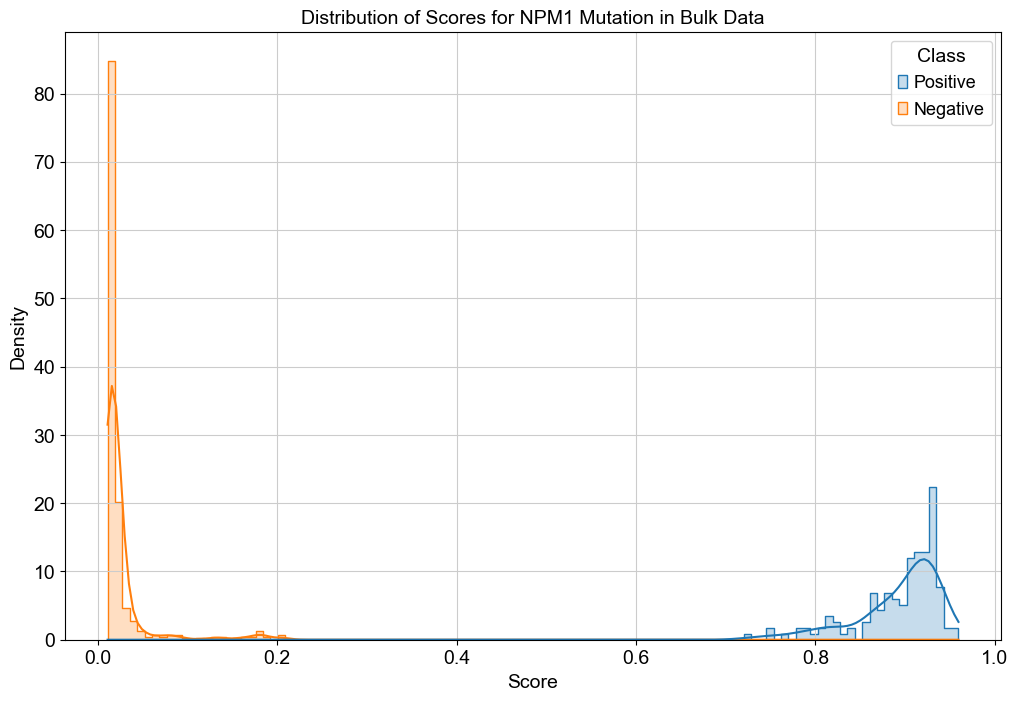

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

mutation = 'NPM1'

# Assuming bulk RNA-seq data predictions and true labels are available
bulk_y_true = mut_data_agg[mutation].astype(int)
ridge_bulk_probs = predictions[f'ridge_bulk_probs_{mutation}']

# Separate the scores based on ground truth labels
positive_scores = ridge_bulk_probs[bulk_y_true == 1]
negative_scores = ridge_bulk_probs[bulk_y_true == 0]

# Create a DataFrame for easier plotting with seaborn
import pandas as pd

scores_df = pd.DataFrame({
    'Scores': np.concatenate([positive_scores, negative_scores]),
    'Class': ['Positive'] * len(positive_scores) + ['Negative'] * len(negative_scores)
})

# Plot the distribution of scores for positive and negative samples
plt.figure(figsize=(12, 8))
sns.histplot(data=scores_df, x='Scores', hue='Class', kde=True, element='step', stat='density', common_norm=False)
plt.title(f'Distribution of Scores for {mutation} Mutation in Bulk Data')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()


In [137]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)  # Reduce to 50 components
X_pca = pca.fit_transform(X_scRNA_pca_scaled)
print(f"Shape after PCA: {X_pca.shape}")



Shape after PCA: (8487, 50)


In [138]:
print("Available columns in scRNA_data.obs:")
print(scRNA_data.obs.columns)

Available columns in scRNA_data.obs:
Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes',
       'dataset'],
      dtype='object')


In [156]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Check the shape and content of the data
#print("Shape of X_scRNA_pca_scaled:", X_scRNA_pca_scaled.shape)
#print("Head of X_scRNA_pca_scaled:\n", pd.DataFrame(X_scRNA_pca_scaled).head())


# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = reducer.fit_transform(X_pca)

# Ensure the UMAP embedding is created correctly
print("Shape of UMAP embedding:", umap_embedding.shape)

# Assuming scRNA_data is an AnnData object and predictions are stored in its obs
predicted_status = predictions[f'ridge_preds_{mutation}']

# Check the predicted status data
print("Predicted status unique values:", predicted_status.unique())

# Create a DataFrame for plotting
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df['predicted_status'] = predicted_status.values

# Ensure the DataFrame is created correctly
print("Head of UMAP DataFrame:\n", umap_df.head())

# Plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='predicted_status', palette='viridis', s=5)
plt.title(f'UMAP of Single-Cell Transcriptomes for {mutation} Mutation')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Predicted Status')
plt.show()



/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Shape of UMAP embedding: (8487, 2)


AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [79]:
print(min(scRNA_data.obs[f'ensemble_preds_{mutation}']))
print(max(scRNA_data.obs[f'ensemble_preds_{mutation}']))


0.06518015050237691
0.5617483774975293


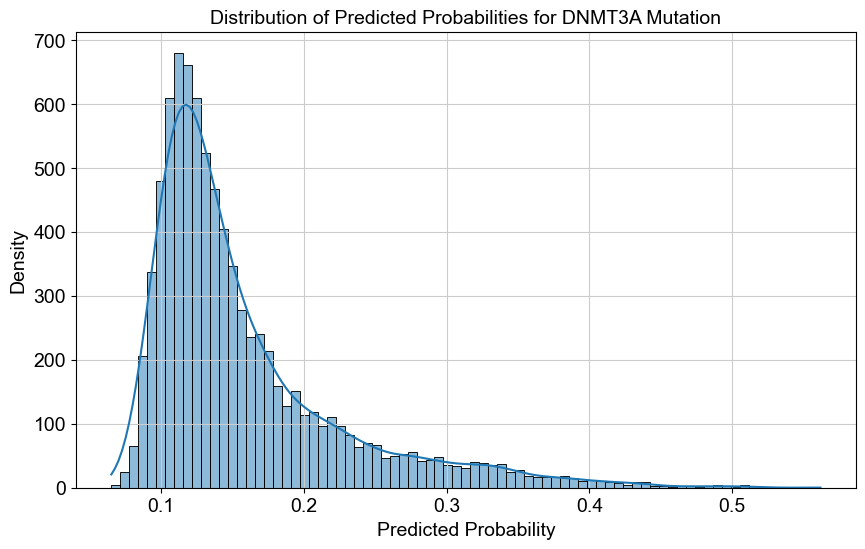

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the predicted probabilities for single-cell RNA-seq data
sc_preds = scRNA_data.obs[f'ensemble_preds_{mutation}']

# Plot the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(sc_preds, kde=True)
plt.title(f'Distribution of Predicted Probabilities for {mutation} Mutation')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()



In [93]:
print(valid_mutations)



['SRSF2', 'ASXL1', 'FLT3', 'BCORL1', 'RUNX1', 'RAD21', 'TP53', 'CCND3', 'PTPN11', 'EZH2', 'IDH1', 'TET2', 'WT1', 'DNMT3A', 'NRAS', 'NF1', 'U2AF1', 'KRAS', 'CEBPA', 'SMC1A', 'KIT', 'JAK2', 'NPM1', 'SF3B1', 'CREBBP', 'GATA2', 'PDS5B', 'BCOR', 'IDH2', 'ZRSR2', 'SMC3', 'PHF6', 'STAG2', 'CBL']


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Assuming scRNA_data is an AnnData object and you have the top variable genes in scRNA_data.var_names

# Extract the gene expression data (X) and convert it to a dense matrix if needed
gene_expression_data = scRNA_data.X

# Perform PCA to reduce dimensionality
pca = PCA(n_components=10)  # You can choose the number of components
pca_result = pca.fit_transform(gene_expression_data)

# Extract predicted mutation status probabilities
#predicted_probs = scRNA_data.obs[f'ensemble_preds_{mutation}']
predicted_probs = scRNA_data.obs[f'{mutation}']

# Define a threshold to binarize the predicted probabilities into predicted status
threshold = 0.9  # Adjust threshold based on your model's characteristics
predicted_status = (predicted_probs >= threshold).astype(int)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['Predicted Status'] = predicted_status.values

# Plot Violin Plots for each principal component
for pc in pca_df.columns[:-1]:  # Exclude the 'Predicted Status' column
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')
    plt.title(f'Expression of {pc} in Predicted vs Non-Predicted Cells for {mutation} Mutation')
    plt.xlabel('Predicted Status')
    plt.ylabel(f'{pc} Expression')
    plt.show()
    


KeyError: 'DNMT3A'

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import umap
import re


# Extract the gene expression data (X) and convert it to a dense matrix if needed
gene_expression_data = scRNA_data.X

# Perform UMAP to reduce dimensionality
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(gene_expression_data)

# Extract predicted mutation status probabilities
predicted_probs = scRNA_data.obs[f'ridge_preds_{mutation}']

# Convert raw scores to probabilities if necessary
if predicted_probs.min() < 0 or predicted_probs.max() > 1:
    predicted_probs = 1 / (1 + np.exp(-predicted_probs))

# Define a threshold to binarize the predicted probabilities into predicted status
threshold = 0.90  # Adjust threshold based on your model's characteristics
predicted_status = (predicted_probs >= threshold).astype(int)

# Extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Select patients to highlight
#selected_patients = ['AML1012', 'AML210A', 'AML419A', 'AML916', 'AML921A', 'AML314', 'AML371', 'AML475', 'AML722B', 'AML870', 'AML997', 'AML329', 'AML420B', 'AML556', 'AML328', 'AML707B', 'AML419A', 'AML328', 'AML707B', 'BM1', 'BM2', 'BM3', 'BM4']  # Example patients, replace with your selections
selected_patients = ['AML210A', 'AML419A', 'AML996', 'AML329', 'AML556', 'BM1', 'BM2', 'BM3', 'BM4']

# Create a DataFrame for plotting
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Predicted Status'] = predicted_status.values
umap_df['Patient'] = scRNA_data.obs['Patient'].values

# Filter DataFrame to include only selected patients if necessary
filtered_umap_df = umap_df[umap_df['Patient'].isin(selected_patients)]

# Plot UMAP scatter plot
plt.figure(figsize=(16, 12))
sns.scatterplot(data=filtered_umap_df, x='UMAP1', y='UMAP2', hue='Patient', style='Predicted Status', palette='viridis', s=10)
plt.title(f'UMAP of Single-Cell Transcriptomes for {mutation} Mutation by Patient')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Patient')
plt.show()



/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


ValueError: cannot assign slice from input of different size

/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_29546/794270936.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)


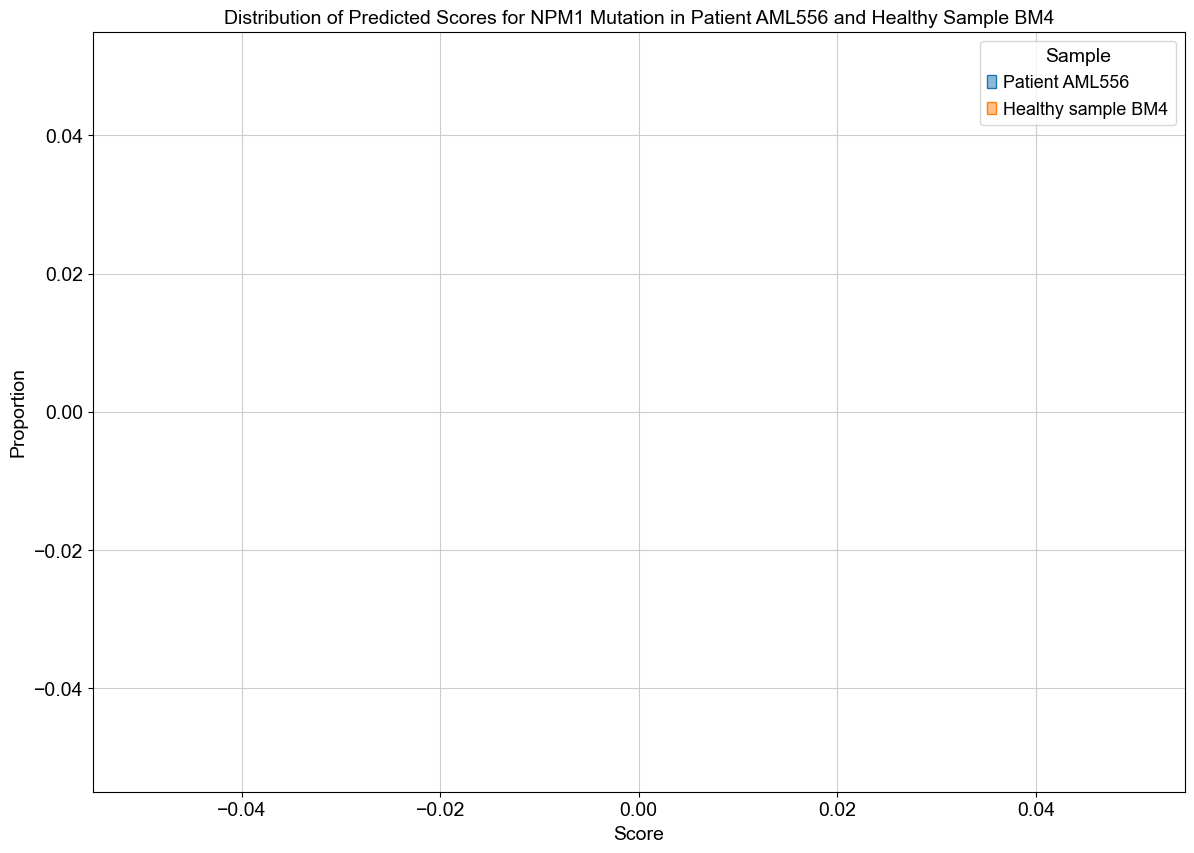

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient and mutation to analyze
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
specific_mutation = 'NPM1'   # Replace with the mutation you want to analyze
healthy_sample = 'BM4'       # Replace with the healthy sample ID you want to include

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Extract predicted mutation status probabilities for the specific mutation
predicted_probs = scRNA_data.obs[f'ensemble_preds_{specific_mutation}']

# Convert raw scores to probabilities if necessary
#if predicted_probs.min() < 0 or predicted_probs.max() > 1:
#    predicted_probs = 1 / (1 + np.exp(-predicted_probs))

# Filter for the specific patient and healthy sample
patient_scores = predicted_probs[scRNA_data.obs['Patient'] == specific_patient]
healthy_scores = predicted_probs[scRNA_data.obs['Patient'] == healthy_sample]

# Create a DataFrame for easier plotting with seaborn
scores_df = pd.DataFrame({
    'Scores': np.concatenate([patient_scores, healthy_scores]),
    'Sample': ['Patient'] * len(patient_scores) + ['Healthy'] * len(healthy_scores)
})

# Plot the distribution of scores for the specified mutation in the specific patient and healthy sample
plt.figure(figsize=(14, 10))

# Plot each sample type separately to ensure labels are included
sns.histplot(data=scores_df[scores_df['Sample'] == 'Patient'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=25, label='Patient ' + specific_patient)
sns.histplot(data=scores_df[scores_df['Sample'] == 'Healthy'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=25, label='Healthy sample ' + healthy_sample)

# Manually add the legend
plt.legend(title='Sample')

plt.title(f'Distribution of Predicted Scores for {specific_mutation} Mutation in Patient {specific_patient} and Healthy Sample {healthy_sample}')
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.show()


In [75]:
# Create a Series with patient names
patient_names = scRNA_data.obs['Patient'].apply(lambda x: x.split('_')[0] if '_' in x else x.split('-')[0])

# Print all unique patient names
unique_patient_names = patient_names.unique()
print(unique_patient_names)


['Unknown']


In [76]:
print(scRNA_data.obs['Patient'])


AAACCAAAGCAACCTA-1-0    Unknown
AAACCAAAGCGATGTC-1-0    Unknown
AAACCAAAGCTATGAT-1-0    Unknown
AAACCAAAGGTATCTG-1-0    Unknown
AAACCAAAGTAATCAC-1-0    Unknown
                         ...   
TGTGTTAGTTTCACTT-1-0    Unknown
TGTGTTGAGCAACTGC-1-0    Unknown
TGTGTTGAGTCAGGAG-1-0    Unknown
TGTGTTGAGTGATGCC-1-0    Unknown
TGTGTTGAGTTACCCT-1-0    Unknown
Name: Patient, Length: 8487, dtype: object


In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

def plot_patient_vs_healthy(scRNA_data, specific_patient, specific_mutation):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Extract predicted mutation status probabilities for the specific mutation
    predicted_probs = scRNA_data.obs[f'ridge_preds_{specific_mutation}']
    #predicted_probs = scRNA_data.obs[f'ensemble_preds_{specific_mutation}']

    # Filter for the specific patient and all healthy samples
    #patient_scores = predicted_probs[scRNA_data.obs['Patient'] == specific_patient]
    #patient_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith(specific_patient)]
    patient_scores = predicted_probs[scRNA_data.obs_names.str.startswith(specific_patient)]
    healthy_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith('BM')]

    # Create a DataFrame for easier plotting with seaborn
    scores_df = pd.DataFrame({
        'Scores': np.concatenate([patient_scores, healthy_scores]),
        'Sample': ['Patient'] * len(patient_scores) + ['Healthy'] * len(healthy_scores)
    })

    # Plot the distribution of scores for the specified mutation in the specific patient and healthy samples
    plt.figure(figsize=(14, 10))

    # Plot each sample type separately to ensure labels are included
    sns.histplot(data=scores_df[scores_df['Sample'] == 'Patient'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='Patient ' + specific_patient)
    sns.histplot(data=scores_df[scores_df['Sample'] == 'Healthy'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='Healthy samples')
    #sns.histplot(data=scores_df[scores_df['Sample'] == 'Patient'], x='Scores', kde=True, element='step', stat='count', common_norm=False, bins=100, label='Patient ' + specific_patient)
    #sns.histplot(data=scores_df[scores_df['Sample'] == 'Healthy'], x='Scores', kde=True, element='step', stat='count', common_norm=False, bins=100, label='Healthy samples')

    # Manually add the legend
    plt.legend(title='Sample')

    plt.title(f'Distribution of Predicted Scores for {specific_mutation} Mutation in Patient {specific_patient} and 4 Healthy Samples')
    plt.xlabel('Score')
    plt.ylabel('Proportion')
    #plt.ylabel('Count')
    plt.show()

# Example usage
# NOTE: Patient AML556 has a .D0, .D15, and .D31
specific_patient = 'AML1012'
#specific_patient = 'AML556.D0'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML556.D15'
#specific_patient = 'AML556.D31'
#specific_patient = 'AML328'
#specific_patient = 'AML328.D0'
#specific_patient = 'AML328.D29'
#specific_patient = 'AML328.D113'
#specific_patient = 'AML328.D171'
#specific_patient = 'AML916'
#specific_patient = 'AML419A'
#specific_patient = 'AML475'
#specific_patient = 'AML1012'
#specific_patient = 'AML556'
#specific_patient = 'AML328'
#specific_patient = 'AML707B'
#specific_patient = 'AML707B.D0'
#specific_patient = 'AML707B.D18'
#specific_patient = 'AML707B.D41'
#specific_patient = 'AML707B.D97'
#specific_patient = 'AML707B.D113'
#specific_patient = 'AML921A'
specific_patient = 'AML210A'
#specific_patient = 'AML722B'
#specific_patient = 'AML870.D0'
#specific_patient = 'AML870.D14'
#specific_patient = 'AML997.D0'
#specific_patient = 'AML329.D0'
#specific_patient = 'AML329.D20'
#specific_patient = 'AML329.D37'
#specific_patient = 'AML420B.D0'
#specific_patient = 'OCI'
#specific_patient = 'MUTZ'

#specific_mutation = 'DNMT3A'   # Replace with the mutation you want to analyze
specific_mutation = 'NPM1'
#specific_mutation = 'KRAS'
#specific_mutation = 'NRAS'
#specific_mutation = 'TET2'
#specific_mutation = 'FLT3'
#specific_mutation = 'TP53'
#specific_mutation = 'KIT'
#specific_mutation = 'RAD21'
#specific_mutation = 'BRCC3'
#specific_mutation = 'RUNX1'
#specific_mutation = 'CEBPA'
#specific_mutation = 'BCORL1'
#specific_mutation = 'IDH2'
#specific_mutation = 'ASXL1'
#specific_mutation = 'PTPN11'
#specific_mutation = 'ZRSR2'
#specific_mutation = 'SMC3'
#specific_mutation = 'STAG2'
#specific_mutation = 'PHF6'
#specific_mutation = 'SF3B1'
#specific_mutation = 'GATA2'

plot_patient_vs_healthy(scRNA_data, specific_patient, specific_mutation)



/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_29546/2071684693.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)


KeyError: 'ridge_preds_NPM1'

In [78]:
# Plot UMAP for AML patient versus normal samples
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import umap
import scanpy as sc

def plot_umap_patient_vs_healthy(scRNA_data, specific_patient):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Filter for the specific patient and all healthy samples
    patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]
    healthy_data = scRNA_data[scRNA_data.obs['Patient'].str.startswith('BM')]

    # Combine patient and healthy data
    combined_data = patient_data.concatenate(healthy_data)

    # Create UMAP embeddings
    sc.pp.normalize_total(combined_data, target_sum=1e4)
    sc.pp.log1p(combined_data)
    sc.pp.highly_variable_genes(combined_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
    combined_data = combined_data[:, combined_data.var.highly_variable]
    sc.pp.scale(combined_data, max_value=10)
    sc.pp.pca(combined_data, n_comps=50)
    sc.pp.neighbors(combined_data, n_neighbors=10, n_pcs=40)
    sc.tl.umap(combined_data)

    # Plot UMAP
    plt.figure(figsize=(14, 10))
    sc.pl.umap(combined_data, color='Patient', title=f'UMAP of {specific_patient} and Healthy Samples', show=True)

# Example usage
#specific_patient = 'AML419A'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML707B'
#specific_patient = 'AML556'
specific_patient = 'AML1012'
plot_umap_patient_vs_healthy(scRNA_data, specific_patient)



/var/folders/2k/tcn7b4hn3c9dls2qttgfhg84_b9kmx/T/ipykernel_29546/2333171053.py:23: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = patient_data.concatenate(healthy_data)
/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/merge.py:1287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_annot[label] = label_col
/Users/hamiltsy/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/_core/merge.py:1287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient to analyze
#specific_patient = 'AML707B'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML556'
#specific_patient = 'AML1012'
specific_patient = 'AML328'

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Identify all mutation score columns (assuming they start with 'ridge_preds_')
mutation_columns = [col for col in scRNA_data.obs.columns if col.startswith('ensemble_preds_')]
#mutation_columns = [col for col in scRNA_data.obs.columns if col.startswith('ridge_preds_')]

# Create a DataFrame to hold scores for all mutations
all_mutation_scores = pd.DataFrame()

for mutation in mutation_columns:
    mutation_name = mutation.replace('ensemble_preds_', '')
    #mutation_name = mutation.replace('ridge_preds_', '')
    scores = patient_data.obs[mutation]
    temp_df = pd.DataFrame({
        'Scores': scores,
        'Mutation': mutation_name
    })
    all_mutation_scores = pd.concat([all_mutation_scores, temp_df])

# Plot the distribution of scores for all mutations in the specific patient
plt.figure(figsize=(14, 10))

# Plot each mutation separately to ensure labels are included
for mutation_name in all_mutation_scores['Mutation'].unique():
    sns.histplot(
        data=all_mutation_scores[all_mutation_scores['Mutation'] == mutation_name],
        x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label=mutation_name
        #x='Scores', kde=True, element='step', stat='frequency', common_norm=False, bins=100, label=mutation_name
    )

plt.title(f'Distribution of Predicted Scores for All Mutations in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Proportion')
#plt.ylabel('Frequency')
plt.legend(title='Mutation')
plt.show()



KeyError: 'Mutation'

<Figure size 700x500 with 0 Axes>

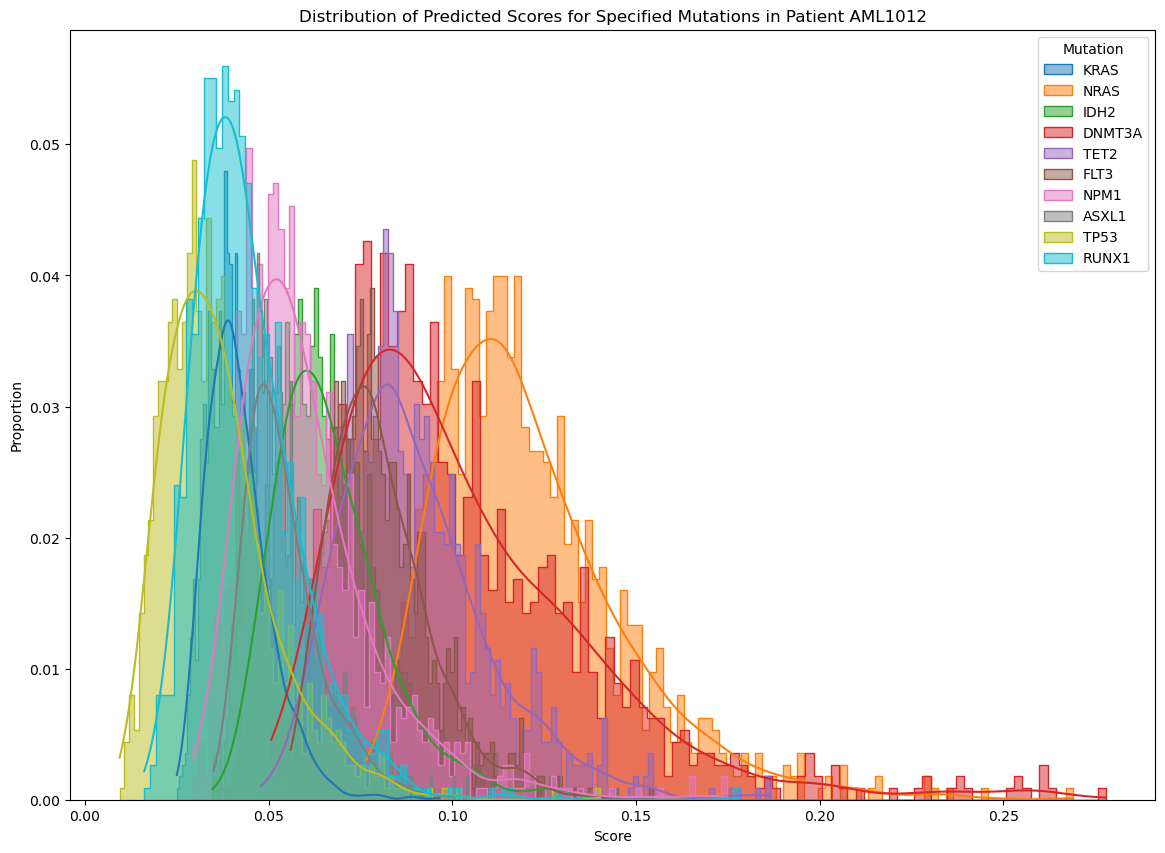

In [49]:
# The same as above only user-specified mutations are plotted
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient to analyze
#specific_patient = 'AML419A'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML556'
#specific_patient = 'AML210A'
specific_patient = 'AML1012'
#specific_patient = 'AML419A'

# User specifies the mutations to include
#specified_mutations = ['KRAS', 'NRAS', 'SF3B1', 'IDH2', 'ASXL1', 'KIT', 'DNMT3A']
specified_mutations = ['KRAS', 'NRAS', 'IDH2', 'DNMT3A', 'TET2', 'FLT3', 'NPM1', 'ASXL1', 'TP53', 'RUNX1', 'SETD2']  # Replace with the mutation names you want to include
#specified_mutations = ['DNMT3A', 'NPM1', 'NRAS', 'TET2', 'ATM', 'FLT3', 'TP53', 'KRAS', 'CEBPA']

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Identify all mutation score columns (assuming they start with 'svm_preds_')
mutation_columns = [f'ensemble_preds_{mutation}' for mutation in specified_mutations]
#mutation_columns = [f'ridge_preds_{mutation}' for mutation in specified_mutations]

# Create a DataFrame to hold scores for all specified mutations
all_mutation_scores = pd.DataFrame()

for mutation in mutation_columns:
    mutation_name = mutation.replace('ensemble_preds_', '')
    #mutation_name = mutation.replace('ridge_preds_', '')
    if mutation in patient_data.obs.columns:
        scores = patient_data.obs[mutation]
        temp_df = pd.DataFrame({
            'Scores': scores,
            'Mutation': mutation_name
        })
        all_mutation_scores = pd.concat([all_mutation_scores, temp_df])

# Plot the distribution of scores for all specified mutations in the specific patient
plt.figure(figsize=(14, 10))

# Plot each mutation separately to ensure labels are included
for mutation_name in all_mutation_scores['Mutation'].unique():
    sns.histplot(
        data=all_mutation_scores[all_mutation_scores['Mutation'] == mutation_name],
        x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label=mutation_name
    )

plt.title(f'Distribution of Predicted Scores for Specified Mutations in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.legend(title='Mutation')
plt.show()



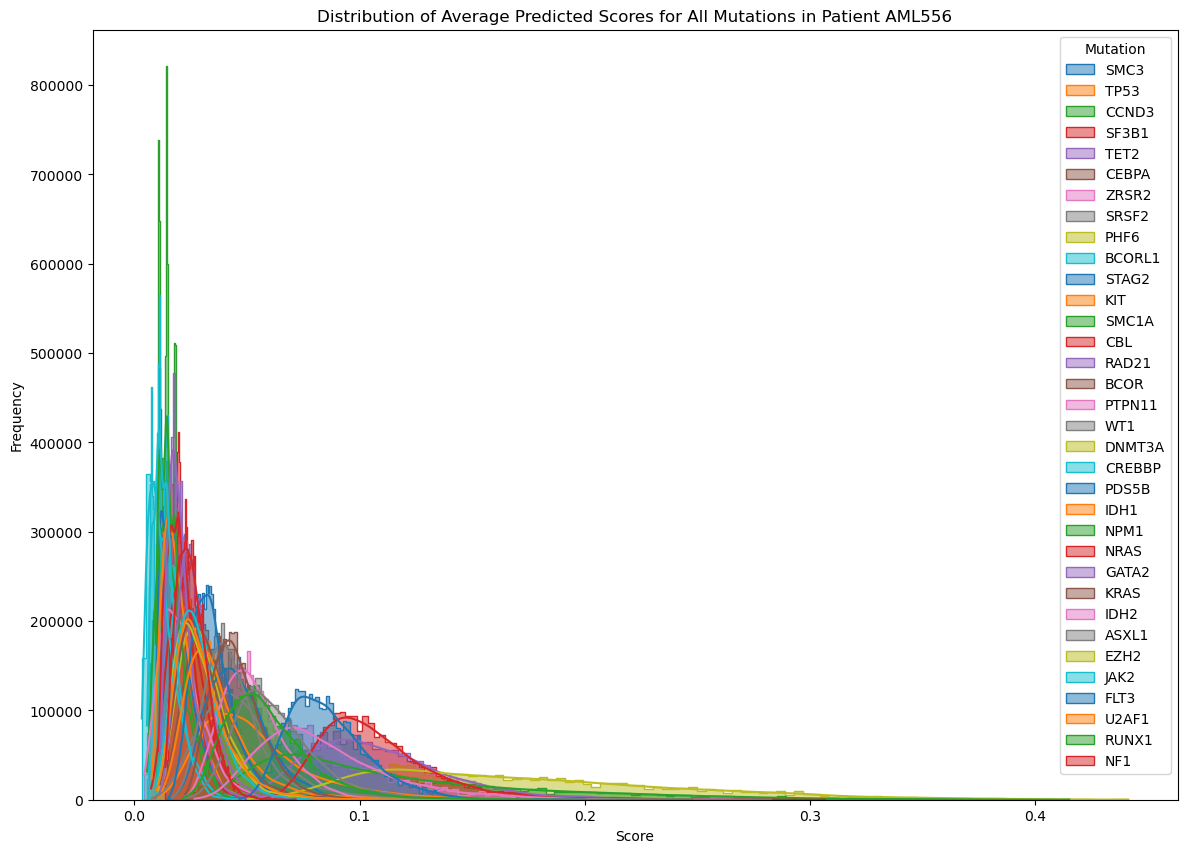

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

def plot_average_classifier_scores(scRNA_data, specific_patient):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Filter for the specific patient
    patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

    # Identify all mutation score columns (assuming they start with 'ridge_preds_', 'svm_preds_', or 'rf_preds_')
    classifiers = ['ridge_preds_', 'svm_preds_', 'rf_preds_']
    mutation_columns = [col.replace('ridge_preds_', '').replace('svm_preds_', '').replace('rf_preds_', '') for col in scRNA_data.obs.columns if col.startswith(tuple(classifiers))]
    mutation_columns = list(set(mutation_columns))  # Remove duplicates

    # Create a DataFrame to hold average scores for all mutations
    all_mutation_scores = pd.DataFrame()

    for mutation in mutation_columns:
        ridge_col = f'ridge_preds_{mutation}'
        svm_col = f'svm_preds_{mutation}'
        rf_col = f'rf_preds_{mutation}'
        
        # Calculate the average score if all three classifiers are present
        if ridge_col in patient_data.obs.columns and svm_col in patient_data.obs.columns and rf_col in patient_data.obs.columns:
            average_scores = patient_data.obs[[ridge_col, svm_col, rf_col]].mean(axis=1)
            temp_df = pd.DataFrame({
                'Scores': average_scores,
                'Mutation': mutation
            })
            all_mutation_scores = pd.concat([all_mutation_scores, temp_df])

    # Plot the distribution of scores for all mutations in the specific patient
    plt.figure(figsize=(14, 10))

    # Plot each mutation separately to ensure labels are included
    for mutation_name in all_mutation_scores['Mutation'].unique():
        sns.histplot(
            data=all_mutation_scores[all_mutation_scores['Mutation'] == mutation_name],
            x='Scores', kde=True, element='step', stat='frequency', common_norm=False, bins=100, label=mutation_name
        )

    plt.title(f'Distribution of Average Predicted Scores for All Mutations in Patient {specific_patient}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend(title='Mutation')
    plt.show()

# Example usage
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
plot_average_classifier_scores(scRNA_data, specific_patient)


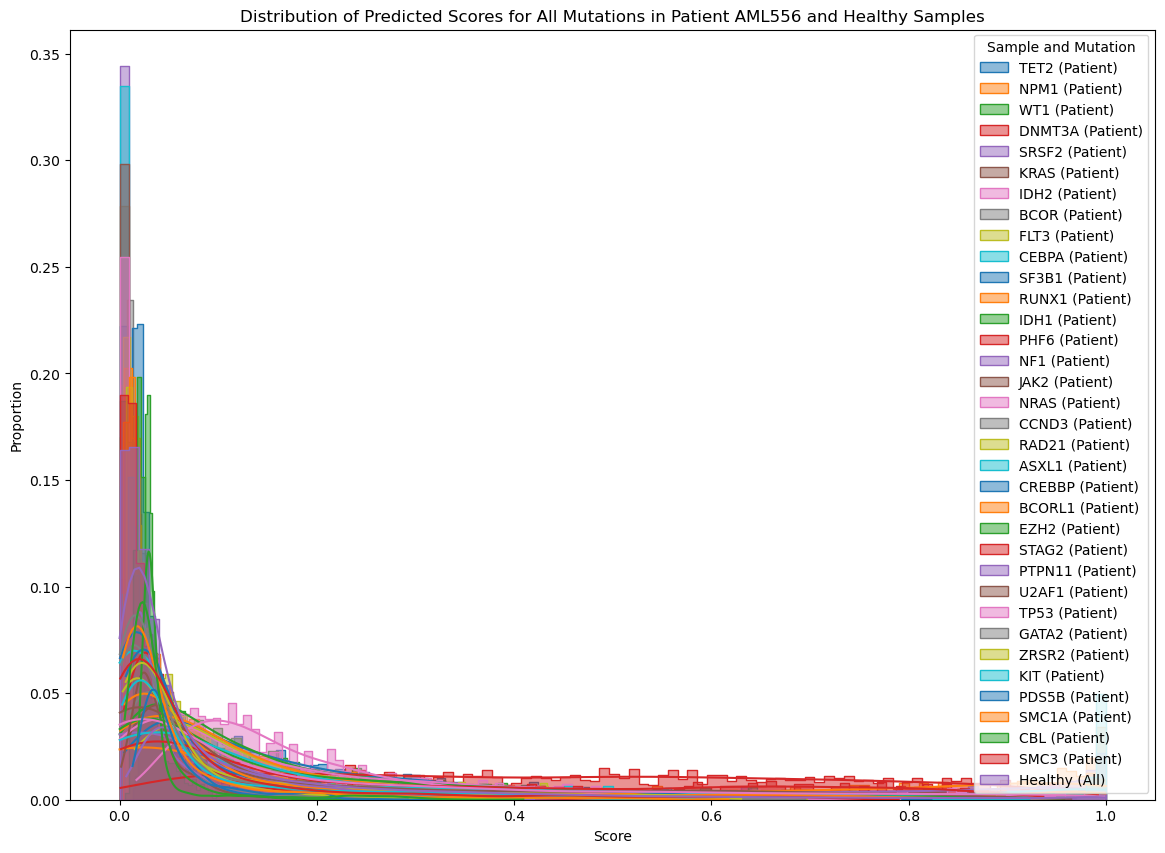

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient to analyze
#specific_patient = 'AML1012'  # Replace with the patient ID you want to analyze
specific_patient = 'AML556' 

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient and healthy samples
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]
healthy_data = scRNA_data[scRNA_data.obs['Patient'].str.startswith('BM')]

# Identify all mutation score columns (assuming they start with 'ridge_preds_')
mutation_columns = [col for col in scRNA_data.obs.columns if col.startswith('ridge_preds_')]

# Create a DataFrame to hold scores for all mutations
all_mutation_scores = pd.DataFrame()

for mutation in mutation_columns:
    mutation_name = mutation.replace('ridge_preds_', '')
    patient_scores = patient_data.obs[mutation]
    healthy_scores = healthy_data.obs[mutation]
    
    temp_df_patient = pd.DataFrame({
        'Scores': patient_scores,
        'Mutation': mutation_name,
        'Sample': 'Patient'
    })
    
    temp_df_healthy = pd.DataFrame({
        'Scores': healthy_scores,
        'Mutation': mutation_name,
        'Sample': 'Healthy'
    })
    
    all_mutation_scores = pd.concat([all_mutation_scores, temp_df_patient, temp_df_healthy])

# Pool all healthy sample scores into a single distribution
pooled_healthy_scores = all_mutation_scores[all_mutation_scores['Sample'] == 'Healthy']['Scores']

# Create a DataFrame for pooled healthy scores
pooled_healthy_df = pd.DataFrame({
    'Scores': pooled_healthy_scores,
    'Sample': 'Healthy'
})

# Plot the distribution of scores for all mutations in the specific patient and pooled healthy samples
plt.figure(figsize=(14, 10))

# Plot each mutation for the patient
for mutation_name in all_mutation_scores['Mutation'].unique():
    sns.histplot(
        data=all_mutation_scores[(all_mutation_scores['Mutation'] == mutation_name) & (all_mutation_scores['Sample'] == 'Patient')],
        x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label=f'{mutation_name} (Patient)'
    )

# Plot the pooled healthy sample scores
sns.histplot(
    data=pooled_healthy_df,
    x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='Healthy (All)'
)

plt.title(f'Distribution of Predicted Scores for All Mutations in Patient {specific_patient} and Healthy Samples')
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.legend(title='Sample and Mutation')
plt.show()



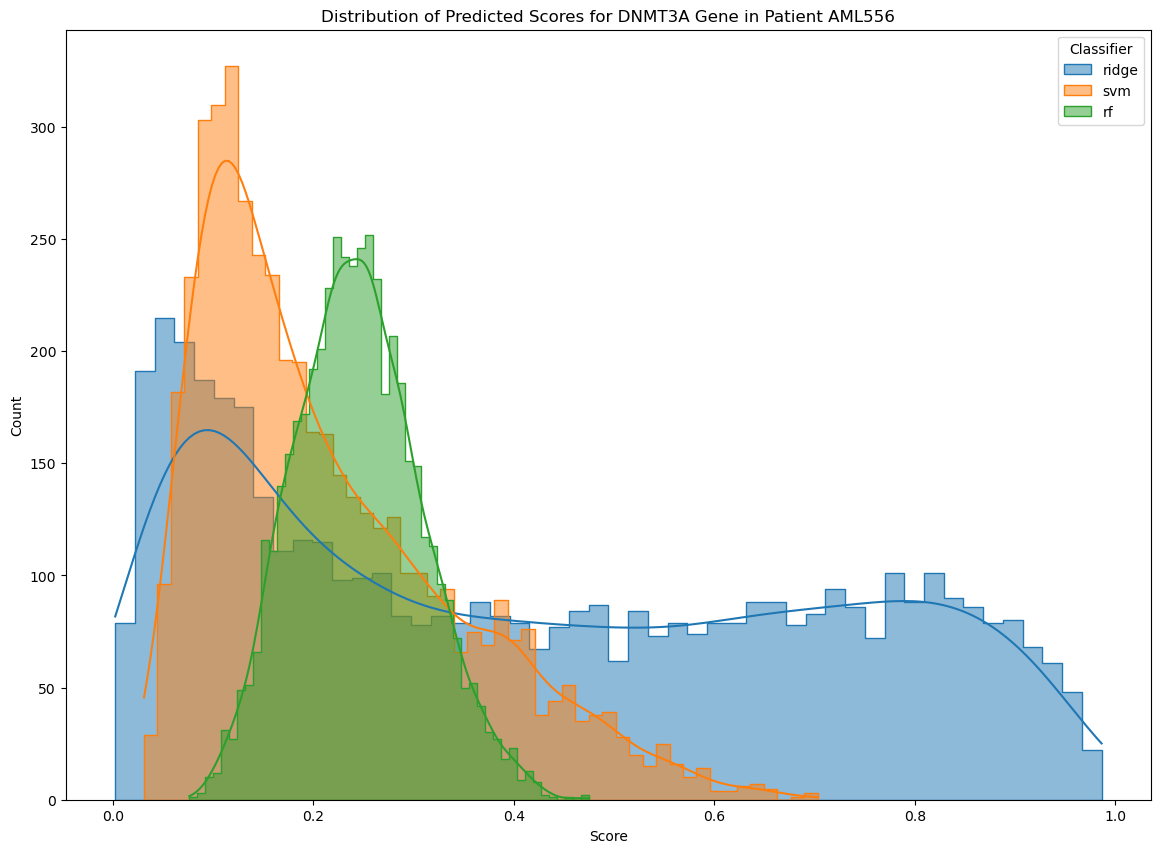

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient and gene to analyze
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
#specific_gene = 'TET2'  # Replace with the gene you want to analyze
specific_gene = 'DNMT3A'  

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Define the classifiers to check
classifiers = ['ridge', 'svm', 'rf']  # Replace with your classifier names if different
#classifiers = ['ridge']

# Create a DataFrame to hold scores for the specific gene from all classifiers
all_classifier_scores = pd.DataFrame()

for classifier in classifiers:
    column_name = f'{classifier}_preds_{specific_gene}'
    if column_name in patient_data.obs.columns:
        scores = patient_data.obs[column_name]
        temp_df = pd.DataFrame({
            'Scores': scores,
            'Classifier': classifier
        })
        all_classifier_scores = pd.concat([all_classifier_scores, temp_df])

# Plot the distribution of scores for the specific gene from all classifiers
plt.figure(figsize=(14, 10))

# Plot each classifier separately to ensure labels are included
for classifier in classifiers:
    sns.histplot(
        data=all_classifier_scores[all_classifier_scores['Classifier'] == classifier],
        x='Scores', kde=True, element='step', stat='count', common_norm=False, bins=50, label=classifier
    )

plt.title(f'Distribution of Predicted Scores for {specific_gene} Gene in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(title='Classifier')
plt.show()


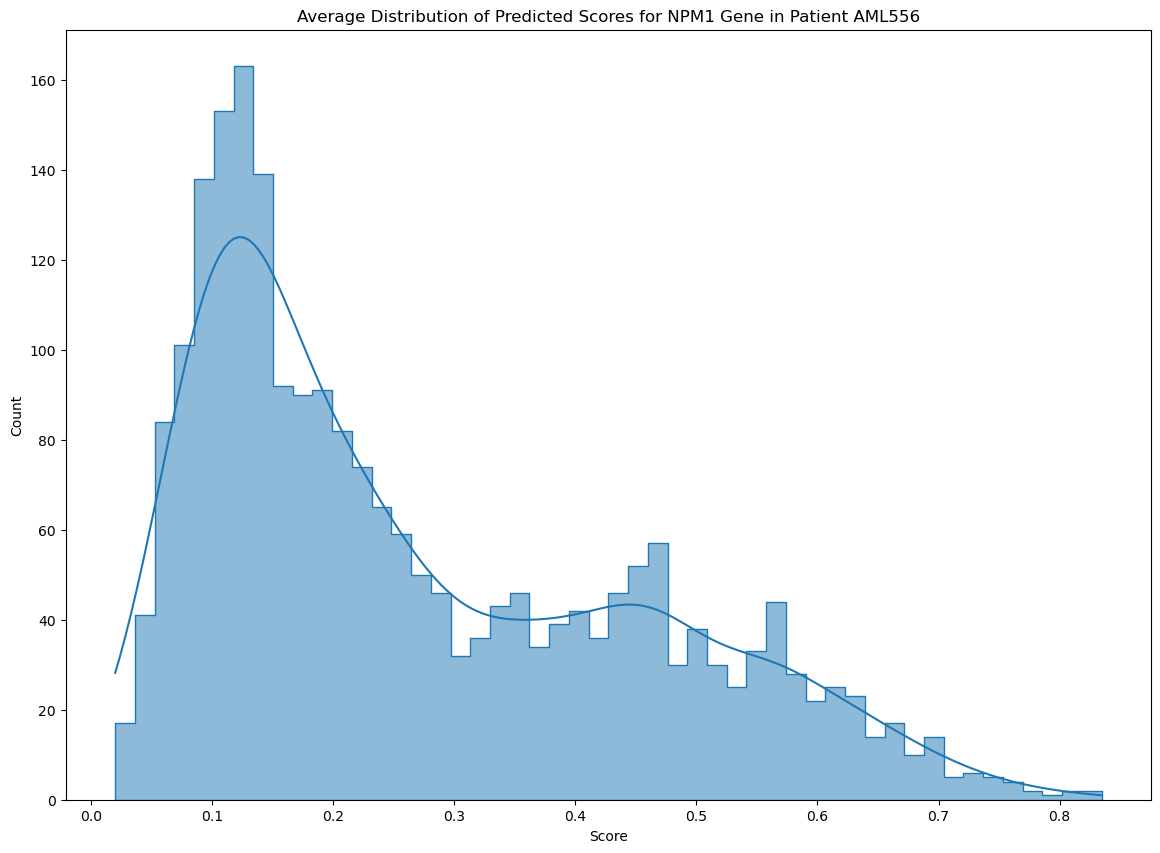

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient and gene to analyze
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
specific_gene = 'NPM1'       # Replace with the gene you want to analyze

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Define the classifiers to check
classifiers = ['ridge', 'svm', 'rf']  # Replace with your classifier names if different

# Create a DataFrame to hold scores for the specific gene from all classifiers
all_classifier_scores = pd.DataFrame(index=patient_data.obs.index)

for classifier in classifiers:
    column_name = f'{classifier}_preds_{specific_gene}'
    if column_name in patient_data.obs.columns:
        all_classifier_scores[classifier] = patient_data.obs[column_name]

# Calculate the average score across all classifiers for each cell
all_classifier_scores['Average_Score'] = all_classifier_scores.mean(axis=1)

# Plot the distribution of the average scores for the specific gene in the specific patient
plt.figure(figsize=(14, 10))
sns.histplot(all_classifier_scores['Average_Score'], kde=True, element='step', stat='count', common_norm=False, bins=50)
plt.title(f'Average Distribution of Predicted Scores for {specific_gene} Gene in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()



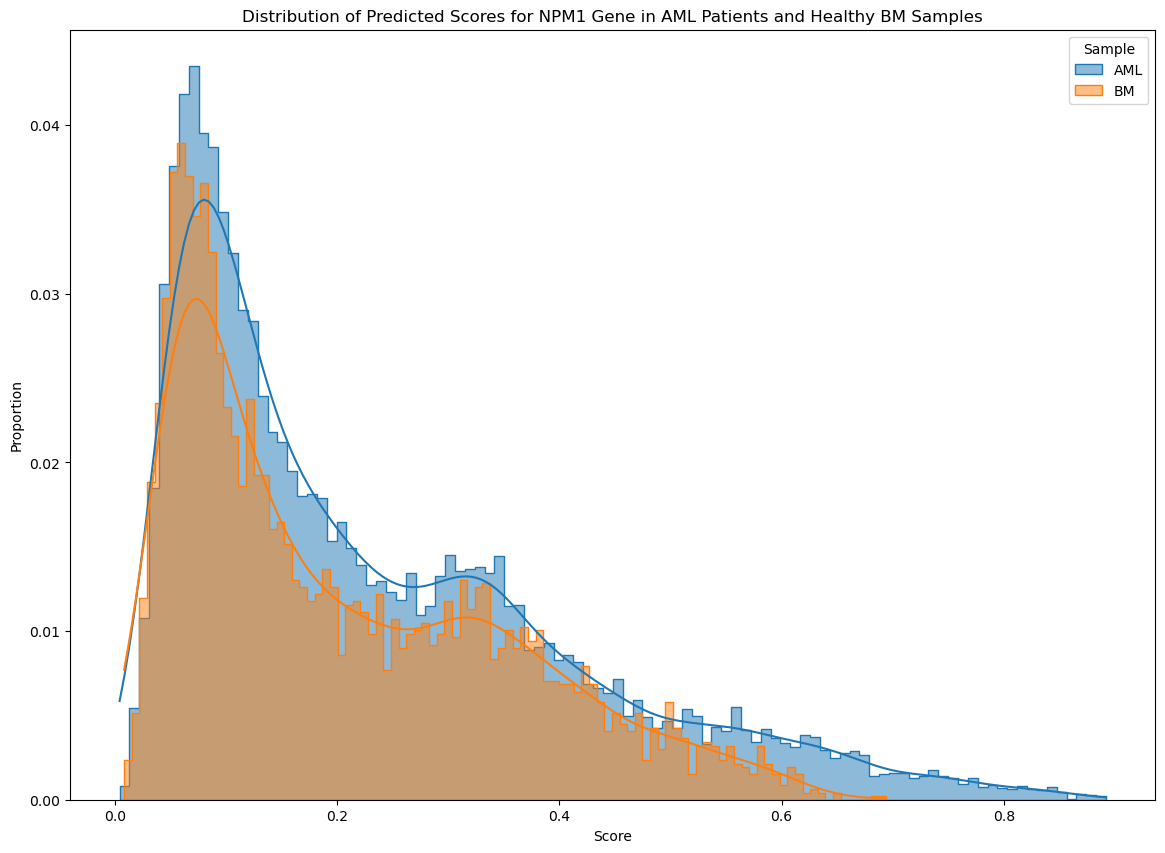

In [533]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

def plot_gene_prediction_distribution(scRNA_data, specific_gene):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Extract predicted mutation status probabilities for the specific gene
    predicted_probs = scRNA_data.obs[f'ensemble_preds_{specific_gene}']

    # Convert raw scores to probabilities if necessary
    # if predicted_probs.min() < 0 or predicted_probs.max() > 1:
    #    predicted_probs = 1 / (1 + np.exp(-predicted_probs))

    # Filter scores for AML patients and healthy BM samples
    aml_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith('AML')]
    bm_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith('BM')]

    # Create a DataFrame for easier plotting with seaborn
    scores_df = pd.DataFrame({
        'Scores': np.concatenate([aml_scores, bm_scores]),
        'Sample': ['AML'] * len(aml_scores) + ['BM'] * len(bm_scores)
    })

    # Plot the distribution of scores for the specified gene
    plt.figure(figsize=(14, 10))
    sns.histplot(data=scores_df[scores_df['Sample'] == 'AML'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='AML')
    sns.histplot(data=scores_df[scores_df['Sample'] == 'BM'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='BM')
    
    # Manually add the legend
    plt.legend(title='Sample')

    plt.title(f'Distribution of Predicted Scores for {specific_gene} Gene in AML Patients and Healthy BM Samples')
    plt.xlabel('Score')
    plt.ylabel('Proportion')
    plt.show()

# Example usage
specific_gene = 'NPM1'  # Replace with the gene you want to analyze
plot_gene_prediction_distribution(scRNA_data, specific_gene)



#### Check predictions versus ground-truth detected mutations in single-cell genotyping calls

In [51]:
# Specify the directory and filename of the ground truth single-cell mutations
mut_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_D0_AML_samples_and_4_healthy_BM_samples/'
mut_tsv_file = 'barcode_mut_transcripts.tsv'


In [52]:
# Read in ground truth single cell mutations to dataframe
sc_mut_ground_truth = pd.read_csv(mut_dir + mut_tsv_file, sep='\t')


In [53]:
print(sc_mut_ground_truth)
#print(set(sc_mut_ground_truth['Barcode']))


                     Barcode MutTranscripts WtTranscripts
0           BM1_AGGCGGGCGTGN            NaN           NaN
1           BM1_ATAACATTTCAC            NaN           NaN
2           BM1_ACGCTCTGGCCN            NaN           NaN
3           BM1_TTGCACAGAGGA            NaN           NaN
4           BM1_TGTATTGCTTTG            NaN           NaN
...                      ...            ...           ...
44818  OCI.AML3_TGAAAACACTTN            NaN           NaN
44819  OCI.AML3_TGCTCGTCGCGT            NaN           NaN
44820  OCI.AML3_TGCTGTCGCGCG            NaN           NaN
44821  OCI.AML3_TGTCCGCGCCCA            NaN           NaN
44822  OCI.AML3_TGTGTCAAGCGA            NaN           NaN

[44823 rows x 3 columns]


In [54]:
# Select which patient and mutation to analyze
#patient = 'AML419A.D0_'
#patient = 'AML1012.D0_'
#patient = 'AML556.D0_'
#patient = 'AML419A'
#patient = 'AML556'
patient = ''
mutation = 'NPM1'
#mutation = 'DNMT3A'
#mutation = 'NRAS'


In [55]:
filtered_df = sc_mut_ground_truth[sc_mut_ground_truth['Barcode'].str.contains(patient)]
print(filtered_df)


                     Barcode MutTranscripts WtTranscripts
0           BM1_AGGCGGGCGTGN            NaN           NaN
1           BM1_ATAACATTTCAC            NaN           NaN
2           BM1_ACGCTCTGGCCN            NaN           NaN
3           BM1_TTGCACAGAGGA            NaN           NaN
4           BM1_TGTATTGCTTTG            NaN           NaN
...                      ...            ...           ...
44818  OCI.AML3_TGAAAACACTTN            NaN           NaN
44819  OCI.AML3_TGCTCGTCGCGT            NaN           NaN
44820  OCI.AML3_TGCTGTCGCGCG            NaN           NaN
44821  OCI.AML3_TGTCCGCGCCCA            NaN           NaN
44822  OCI.AML3_TGTGTCAAGCGA            NaN           NaN

[44823 rows x 3 columns]


In [56]:
filtered_df['MutTranscripts'] = filtered_df['MutTranscripts'].fillna('')
filtered_df['WtTranscripts'] = filtered_df['WtTranscripts'].fillna('')


In [57]:
filtered_df[filtered_df['MutTranscripts'].str.contains(mutation)]
print(filtered_df)


                     Barcode MutTranscripts WtTranscripts
0           BM1_AGGCGGGCGTGN                             
1           BM1_ATAACATTTCAC                             
2           BM1_ACGCTCTGGCCN                             
3           BM1_TTGCACAGAGGA                             
4           BM1_TGTATTGCTTTG                             
...                      ...            ...           ...
44818  OCI.AML3_TGAAAACACTTN                             
44819  OCI.AML3_TGCTCGTCGCGT                             
44820  OCI.AML3_TGCTGTCGCGCG                             
44821  OCI.AML3_TGTCCGCGCCCA                             
44822  OCI.AML3_TGTGTCAAGCGA                             

[44823 rows x 3 columns]


In [58]:
# Filter based on the mutation being in either MutTranscripts or WtTranscripts
# This should eliminate those cells which weren't checked for the mutation of interest
mutation_filtered_df = filtered_df[
    filtered_df['MutTranscripts'].str.contains(mutation) | 
    filtered_df['WtTranscripts'].str.contains(mutation)
]


In [59]:
# Print the filtered dataframe
print(mutation_filtered_df)


                       Barcode    MutTranscripts  \
8059   AML210A.D0_AACTGGTATTTA   NPM1.W288fs/118   
8064   AML210A.D0_AAGAAGCGTCCG  NPM1.W288fs/2935   
8065   AML210A.D0_CCTATACCGCGC                     
8072   AML210A.D0_ACGCCTGGTACN    NPM1.W288fs/39   
8077   AML210A.D0_TATGTAGAGACG    NPM1.W288fs/20   
...                        ...               ...   
26770  AML556.D31_AAGCACCTTTTA                     
26772  AML556.D31_CACGTGAAAGCT                     
26777  AML556.D31_TGCTGTGGGGAG                     
26779  AML556.D31_CGGAATTCCCCT                     
26783  AML556.D31_GTACGCAGGAAN                     

                                           WtTranscripts  
8059                                                      
8064                         NPM1.wt/782 /// NPM1.wt/638  
8065   NPM1.wt/475 /// NPM1.wt/398 /// NPM1.wt/195 //...  
8072                                                      
8077                                                      
...                  

In [60]:
# Extract predicted mutation status probabilities
#predicted_probs = scRNA_data.obs[f'ridge_preds_{mutation}']
predicted_probs = scRNA_data.obs[f'ensemble_preds_{mutation}']
#predicted_probs = scRNA_data.obs[f'svm_preds_{mutation}']

# All mutations
#predicted_probs = scRNA_data.obs


In [61]:
predicted_probs = predicted_probs[predicted_probs.index.str.contains(patient)]
print(predicted_probs.index)


Index(['BM1_AGGCGGGCGTGN-0', 'BM1_ATAACATTTCAC-0', 'BM1_ACGCTCTGGCCN-0',
       'BM1_TTGCACAGAGGA-0', 'BM1_TGTCGTATGGAT-0', 'BM1_GGGCAGGGCACN-0',
       'BM1_AGTGTGAAAATT-0', 'BM1_CTCGAGGATACN-0', 'BM1_GCCCCACTCGGT-0',
       'BM1_GGACCTTCAATN-0',
       ...
       'OCI.AML3_GTCTGTGTAAGN-0', 'OCI.AML3_GTCTTGCTGGCG-0',
       'OCI.AML3_GTTACGAGTTTT-0', 'OCI.AML3_TCAAAGCTGTTT-0',
       'OCI.AML3_TCTTTAGGCGAC-0', 'OCI.AML3_TGAAAACACTTN-0',
       'OCI.AML3_TGCTCGTCGCGT-0', 'OCI.AML3_TGCTGTCGCGCG-0',
       'OCI.AML3_TGTCCGCGCCCA-0', 'OCI.AML3_TGTGTCAAGCGA-0'],
      dtype='object', length=42668)


In [62]:
print(predicted_probs)
print(min(predicted_probs))
print(max(predicted_probs))


BM1_AGGCGGGCGTGN-0         0.064703
BM1_ATAACATTTCAC-0         0.050719
BM1_ACGCTCTGGCCN-0         0.057295
BM1_TTGCACAGAGGA-0         0.038291
BM1_TGTCGTATGGAT-0         0.032475
                             ...   
OCI.AML3_TGAAAACACTTN-0    0.055256
OCI.AML3_TGCTCGTCGCGT-0    0.046650
OCI.AML3_TGCTGTCGCGCG-0    0.161926
OCI.AML3_TGTCCGCGCCCA-0    0.057825
OCI.AML3_TGTGTCAAGCGA-0    0.062645
Name: ensemble_preds_NPM1, Length: 42668, dtype: float64
0.02601489332264542
0.4435836468124316


In [63]:
#threshold = .75
#predicted_probs_above_thresh = predicted_probs[predicted_probs >= threshold]


In [64]:
#print(predicted_probs_above_thresh)


In [65]:
print(mutation_filtered_df)


                       Barcode    MutTranscripts  \
8059   AML210A.D0_AACTGGTATTTA   NPM1.W288fs/118   
8064   AML210A.D0_AAGAAGCGTCCG  NPM1.W288fs/2935   
8065   AML210A.D0_CCTATACCGCGC                     
8072   AML210A.D0_ACGCCTGGTACN    NPM1.W288fs/39   
8077   AML210A.D0_TATGTAGAGACG    NPM1.W288fs/20   
...                        ...               ...   
26770  AML556.D31_AAGCACCTTTTA                     
26772  AML556.D31_CACGTGAAAGCT                     
26777  AML556.D31_TGCTGTGGGGAG                     
26779  AML556.D31_CGGAATTCCCCT                     
26783  AML556.D31_GTACGCAGGAAN                     

                                           WtTranscripts  
8059                                                      
8064                         NPM1.wt/782 /// NPM1.wt/638  
8065   NPM1.wt/475 /// NPM1.wt/398 /// NPM1.wt/195 //...  
8072                                                      
8077                                                      
...                  

In [66]:
# Remove the '-0' suffix from all indices
#predicted_scores.index = predicted_scores.index.str.replace('-0$', '', regex=True)


In [67]:
#print(predicted_scores)
#print(type(predicted_scores))


In [68]:
#for index in predicted_scores.index:
#    print(predicted_scores.loc[index])


In [69]:
#print(mutation_filtered_df)


In [70]:
# Remove the '-0' suffix from all indices
predicted_probs.index = predicted_probs.index.str.replace('-0$', '', regex=True)

print(predicted_probs)


BM1_AGGCGGGCGTGN         0.064703
BM1_ATAACATTTCAC         0.050719
BM1_ACGCTCTGGCCN         0.057295
BM1_TTGCACAGAGGA         0.038291
BM1_TGTCGTATGGAT         0.032475
                           ...   
OCI.AML3_TGAAAACACTTN    0.055256
OCI.AML3_TGCTCGTCGCGT    0.046650
OCI.AML3_TGCTGTCGCGCG    0.161926
OCI.AML3_TGTCCGCGCCCA    0.057825
OCI.AML3_TGTGTCAAGCGA    0.062645
Name: ensemble_preds_NPM1, Length: 42668, dtype: float64


In [71]:
'''
# Old version
transcript_dict = {'Mutant': [], 'Wildtype': []}

# Iterate through the DataFrame using iterrows()
for index, row in mutation_filtered_df.iterrows():
    if row['MutTranscripts'] != '' and row['WtTranscripts'] == '':
        print(row['Barcode'])
        print('Mutant transcript: ' + row['MutTranscripts'])
        print('WT transcript: ' + row['WtTranscripts'])
        if row['Barcode'] in predicted_probs.index:
            print('Predicted mutation score: ' + str(predicted_probs.loc[row['Barcode']]))
            transcript_dict['Mutant'].append(predicted_probs.loc[row['Barcode']])
        else:
            print('No mutation predicted for this cell!')
    if row['WtTranscripts'] != '' and row['MutTranscripts'] == '':
        transcript_dict['Wildtype'].append(predicted_probs.loc[row['Barcode']])
'''

"\n# Old version\ntranscript_dict = {'Mutant': [], 'Wildtype': []}\n\n# Iterate through the DataFrame using iterrows()\nfor index, row in mutation_filtered_df.iterrows():\n    if row['MutTranscripts'] != '' and row['WtTranscripts'] == '':\n        print(row['Barcode'])\n        print('Mutant transcript: ' + row['MutTranscripts'])\n        print('WT transcript: ' + row['WtTranscripts'])\n        if row['Barcode'] in predicted_probs.index:\n            print('Predicted mutation score: ' + str(predicted_probs.loc[row['Barcode']]))\n            transcript_dict['Mutant'].append(predicted_probs.loc[row['Barcode']])\n        else:\n            print('No mutation predicted for this cell!')\n    if row['WtTranscripts'] != '' and row['MutTranscripts'] == '':\n        transcript_dict['Wildtype'].append(predicted_probs.loc[row['Barcode']])\n"

In [72]:
transcript_dict = {'Mutant': [], 'Wildtype': []}

# Iterate through the DataFrame using iterrows()
for index, row in mutation_filtered_df.iterrows():
    barcode = row['Barcode']
    #barcode_with_suffix = barcode + '-scRNA'
    barcode_with_suffix = barcode
    
    #if row['MutTranscripts'] != '' and row['WtTranscripts'] == '':
    if row['MutTranscripts'] != '':
        print(barcode)
        print('Mutant transcript: ' + row['MutTranscripts'])
        print('WT transcript: ' + row['WtTranscripts'])
        
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
            
            print('Predicted mutation score: ' + str(predicted_score))
            transcript_dict['Mutant'].append(predicted_score)
        else:
            print('No mutation predicted for this cell!')
    
    #if row['WtTranscripts'] != '' and row['MutTranscripts'] == '':
    if row['WtTranscripts'] != '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Wildtype'].append(predicted_score)


AML210A.D0_AACTGGTATTTA
Mutant transcript: NPM1.W288fs/118
WT transcript: 
Predicted mutation score: 0.07818927000898446
AML210A.D0_AAGAAGCGTCCG
Mutant transcript: NPM1.W288fs/2935
WT transcript: NPM1.wt/782 /// NPM1.wt/638
Predicted mutation score: 0.24627779296334407
AML210A.D0_ACGCCTGGTACN
Mutant transcript: NPM1.W288fs/39
WT transcript: 
Predicted mutation score: 0.0801768458759823
AML210A.D0_TATGTAGAGACG
Mutant transcript: NPM1.W288fs/20
WT transcript: 
Predicted mutation score: 0.12051104855183802
AML210A.D0_TTGTTTTGAAGN
Mutant transcript: NPM1.W288fs/128
WT transcript: 
Predicted mutation score: 0.06387960890308779
AML210A.D0_CTGGGTTGTCCG
Mutant transcript: NPM1.W288fs/2149
WT transcript: 
Predicted mutation score: 0.07135941119701521
AML210A.D0_GATTGATTTTGN
Mutant transcript: NPM1.W288fs/10
WT transcript: 
No mutation predicted for this cell!
AML210A.D0_CATAGTCGTGCT
Mutant transcript: NPM1.W288fs/1478
WT transcript: 
No mutation predicted for this cell!
AML210A.D0_CATTCGTTCGGN


WT transcript: 
No mutation predicted for this cell!
AML419A.D0_ATGTGCATTAAN
Mutant transcript: NPM1.W288fs/600
WT transcript: FLT3.N841wt/2312
Predicted mutation score: 0.12120911798017286
AML419A.D0_GGAGACTATATG
Mutant transcript: NPM1.W288fs/3328
WT transcript: 
Predicted mutation score: 0.1885219422729888
AML419A.D0_TAACGAGTCTCG
Mutant transcript: NPM1.W288fs/52
WT transcript: 
Predicted mutation score: 0.08066193147797035
AML419A.D0_TGTAGAGAATCN
Mutant transcript: NPM1.W288fs/133
WT transcript: 
Predicted mutation score: 0.16284608584102137
AML419A.D0_CGCGAGCTGTAT
Mutant transcript: NPM1.W288fs/57
WT transcript: 
Predicted mutation score: 0.12972000359051297
AML419A.D0_AAGTCGCCAGTC
Mutant transcript: NPM1.W288fs/30
WT transcript: 
Predicted mutation score: 0.10118991691567793
AML419A.D0_GACCCGAATGGC
Mutant transcript: NPM1.W288fs/354
WT transcript: 
Predicted mutation score: 0.22679640870273518
AML419A.D0_GTAATACGCGAG
Mutant transcript: NPM1.W288fs/120
WT transcript: 
Predicted mu

AML556.D0_GGCCCCGGTTAN
Mutant transcript: NPM1.W288fs/57
WT transcript: 
Predicted mutation score: 0.1571118630425798
AML556.D0_GGCCTCGACAGG
Mutant transcript: NPM1.W288fs/910
WT transcript: 
Predicted mutation score: 0.07543982018179478
AML556.D0_GGCGGTCAGTCN
Mutant transcript: NPM1.W288fs/53
WT transcript: 
Predicted mutation score: 0.12296217579394914
AML556.D0_GGCGTATCATAG
Mutant transcript: NPM1.W288fs/792
WT transcript: 
Predicted mutation score: 0.11229465628093233
AML556.D0_GGCTCAGATTAN
Mutant transcript: NPM1.W288fs/9061
WT transcript: 
Predicted mutation score: 0.09639765790323132
AML556.D0_GGGTGCACGGAA
Mutant transcript: NPM1.W288fs/3229 /// NPM1.W288fs/1323
WT transcript: 
Predicted mutation score: 0.10009758081211367
AML556.D0_GGGTTAGTCCCT
Mutant transcript: NPM1.W288fs/3958
WT transcript: 
Predicted mutation score: 0.23923158310149126
AML556.D0_GGTATAGGCAGN
Mutant transcript: NPM1.W288fs/807
WT transcript: NPM1.wt/149
Predicted mutation score: 0.21944235393155218
AML556.D

AML556.D15_TTGCCTAGACTA
Mutant transcript: ATM.G2023R/1101
WT transcript: NPM1.wt/19
Predicted mutation score: 0.08444367922887253
AML556.D31_CAAATACGGTCN
Mutant transcript: ATM.G2023R/1733
WT transcript: NPM1.wt/11176
Predicted mutation score: 0.0712431008431703
AML556.D31_TCACAGACCGCN
Mutant transcript: ATM.G2023R/13
WT transcript: NPM1.wt/5889 /// NPM1.wt/22
Predicted mutation score: 0.06659566823229761


In [73]:
print(transcript_dict)


{'Mutant': [0.07818927000898446, 0.24627779296334407, 0.0801768458759823, 0.12051104855183802, 0.06387960890308779, 0.07135941119701521, 0.16337991070389288, 0.11727511278190311, 0.1449055349888944, 0.14629857356480322, 0.10307254380429441, 0.15376473457938106, 0.14626293547854255, 0.08255807278356303, 0.10316324782105168, 0.19625685015938713, 0.12915870831977413, 0.08206653537353485, 0.09352862169273257, 0.12988833308030653, 0.29253445935723965, 0.14933142571969907, 0.04400902097356048, 0.15180007185360603, 0.14912212745574832, 0.15447696073558023, 0.0754567925974809, 0.12226780760854711, 0.08033641570708962, 0.10136376444092307, 0.05448163748651205, 0.07367172498829984, 0.2066106943396633, 0.07008360054663772, 0.1463022920346469, 0.08928614289470471, 0.10295678662779731, 0.1406833077393646, 0.14596138580714366, 0.08513064157054188, 0.12403028883152373, 0.07767175596256727, 0.10588715826024314, 0.1545091745037764, 0.04235147415255859, 0.11213916068206183, 0.1464061257971554, 0.1177152

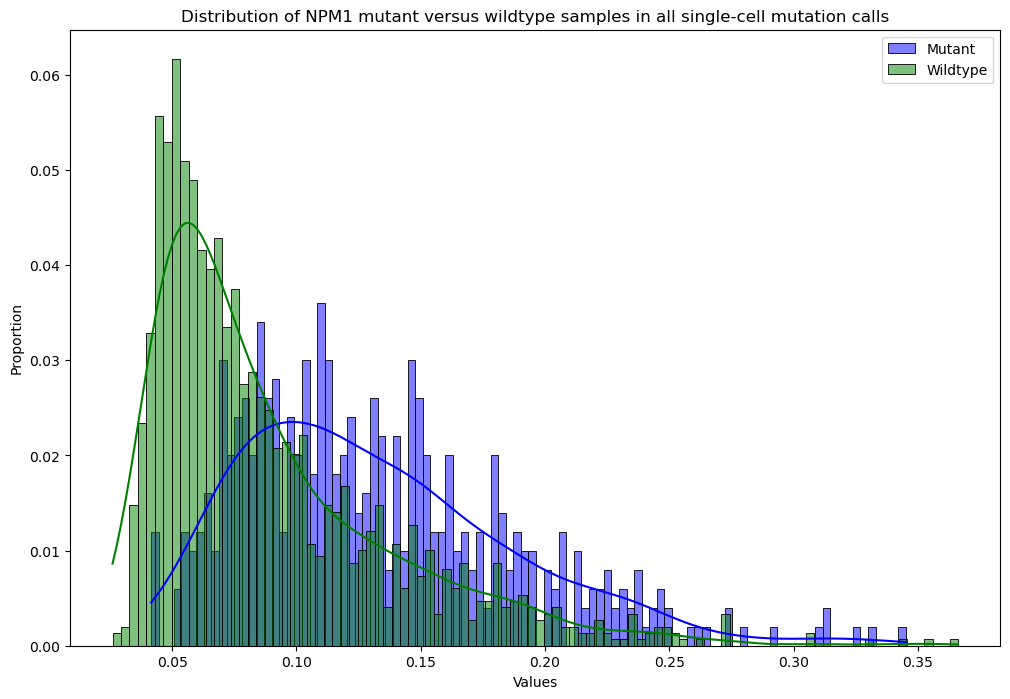

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns


# Convert the data to a DataFrame for easier plotting
df = pd.DataFrame({
    'Value': transcript_dict['Mutant'] + transcript_dict['Wildtype'],
    'Type': ['Mutant'] * len(transcript_dict['Mutant']) + ['Wildtype'] * len(transcript_dict['Wildtype'])
})

# Plot the distributions
plt.figure(figsize=(12, 8))
sns.histplot(df[df['Type'] == 'Mutant']['Value'], color='blue', stat='proportion', kde=True, label='Mutant', bins=100)
sns.histplot(df[df['Type'] == 'Wildtype']['Value'], color='green', stat='proportion', kde=True, label='Wildtype', bins=100)
#sns.histplot(df[df['Type'] == 'Mutant']['Value'], color='blue', stat='count', kde=True, label='Mutant', bins=30)
#sns.histplot(df[df['Type'] == 'Wildtype']['Value'], color='green', stat='count', kde=True, label='Wildtype', bins=30)

# Customize the plot
plt.title('Distribution of NPM1 mutant versus wildtype samples in all single-cell mutation calls')
plt.xlabel('Values')
plt.ylabel('Proportion')
#plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()



In [75]:
transcript_dict = {'Mutant': [], 'Wildtype': [], 'Both': []}

# Iterate through the DataFrame using iterrows()
for index, row in mutation_filtered_df.iterrows():
    barcode = row['Barcode']
    barcode_with_suffix = barcode
    
    if row['MutTranscripts'] != '' and row['WtTranscripts'] == '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Mutant'].append(predicted_score)
        else:
            print('No mutation predicted for this cell!')
    
    elif row['WtTranscripts'] != '' and row['MutTranscripts'] == '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Wildtype'].append(predicted_score)
            
    elif row['MutTranscripts'] != '' and row['WtTranscripts'] != '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Both'].append(predicted_score)
        else:
            print('No mutation predicted for this cell!')


No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
No mutation predicted for this cell!
N

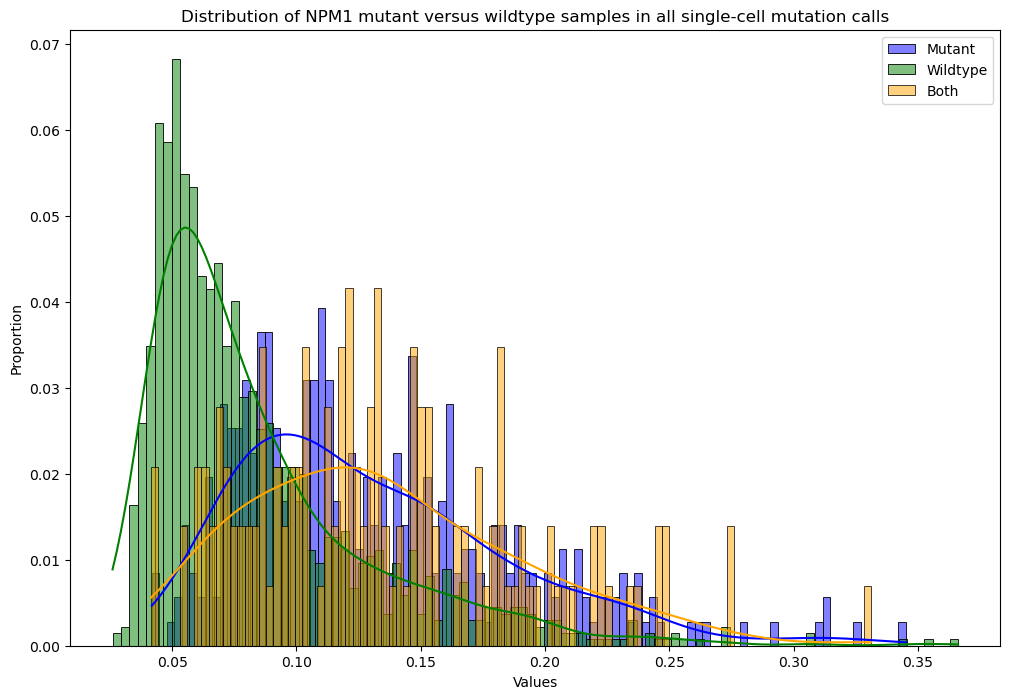

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the data to a DataFrame for easier plotting
df = pd.DataFrame({
    'Value': transcript_dict['Mutant'] + transcript_dict['Wildtype'] + transcript_dict['Both'],
    'Type': ['Mutant'] * len(transcript_dict['Mutant']) + ['Wildtype'] * len(transcript_dict['Wildtype']) + ['Both'] * len(transcript_dict['Both'])
})

# Plot the distributions
plt.figure(figsize=(12, 8))
sns.histplot(df[df['Type'] == 'Mutant']['Value'], color='blue', stat='proportion', kde=True, label='Mutant', bins=100)
sns.histplot(df[df['Type'] == 'Wildtype']['Value'], color='green', stat='proportion', kde=True, label='Wildtype', bins=100)
sns.histplot(df[df['Type'] == 'Both']['Value'], color='orange', stat='proportion', kde=True, label='Both', bins=100)

# Customize the plot
plt.title('Distribution of NPM1 mutant versus wildtype samples in all single-cell mutation calls')
plt.xlabel('Values')
plt.ylabel('Proportion')
plt.legend()

# Show the plot
plt.show()


In [77]:
# Save the results AnnData object
save_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/'
scRNA_data.write(save_dir + '2000_variable_features_scRNA-seq_prediction_probabilities.h5ad')
